# Churn prediction on the cell2cell dataset

## Introduction 


Probably more than others, players in the telco industry suffer from "churn": The move of a customer from one provider to another. In developed markets, the cost of switching providers is increasingly low for the consumer. Reasons include regulation, like transferable phone numbers and an increasingly level playing field in terms of network coverage. At the same time, overall industry growth in terms of number of addressable consumers is slowing down due to high market saturation and maturation. Differentiators like network coverage or exclusive hardware offers are becoming smaller or disappear altogether.

It costs upward of 5 times as much to acquire a new customer than it costs to retain an existing onea, ccording to InvestP https://www.invespcro.com/blog/customer-acquisition-retention/. 
Retaining their customer base by reducing churn is thus a very important part of a telco's customer relationship strategy. This study will seek to help predicting churn to support a churn prevention campaign.

### Problem Statement

Even if preventing churn is considered cheaper customer-by-customer than acquiring a new customer, it comes at a cost. A customer retention campaign might include costly incentives for customers to reconsider churning and extend their contracts. It is most important to target these incentives at the customers most likely to churn, and not "waste" a costly incentive on customers that would have stayed with the provider in the first place.
Predicting which customers are likely to churn, and which are likely to stay thus becomes a critical component of the customer base segmentation for a retention campaign. Neslin, Gupta, et al. estimate that an increase in accuracy of churn prediction of just 0.1 percent can translate to an additional 100,000 USD of profit captured for a mid-size mobile carrier.

This project will develop different models for customer churn prediction on a customer dataset, and select the model with the best performance on predicting if a customer is likely to churn.
In machine learning terms, predicting churn is a binary classification problem. There is one target variable, Churn, which can have 1 of 2 labels: Yes - the customer is leaving this month; No - The customer is staying with the provider. Our machine learning problem solution will take information about the customer as input (such as financial, contractual, or personal), and output the probabilities that a customer belongs to the churner and the non-churner group.


# Implementation

Import general libraries, initialize global parameters and notebook settings.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

# project utilities, review commented code in utils.py
from utils import drop_from

%matplotlib inline

Using TensorFlow backend.


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# global parameters
random_state = 42
np.random.seed(random_state)

# turn performance intensive cells on and off: 
# since this is very performance intensive we only generate the plots when needed. 
with_learning_curves = True

# Param serach can also take a long time 
with_param_search = True

# Run cross validation to collect performance metrics
with_cross_validate = True

# adjust depending on host machine (# of cores, GPU support)
N_JOBS = -1
BATCH_SIZE = 1000

We have outputs that extend vertically, but don't want vertically scrolling iframes to display them

In [4]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

# Dataset

The churn prediction will be done on a dataset of Telco customers. The dataset and its input variables is described in detail in the appendix of V. Umayaparvathi, K. Iyakutt in A Survey on Customer Churn Prediction in Telecom Industry: Datasets, Methods and Metrics. https://www.irjet.net/archives/V3/i4/IRJET-V3I4213.

The dataset was originally donated by an (anonymous) US carrier and published by the Fuqua School of Business at Duke University as part of a machine learning competition. The data was obtained from Kaggle [https://www.kaggle.com/jpacse/datasets-for-churn-telecom/downloads/datasets-for-churn-telecom.zip/2]

The dataset consists of 58 variables describing a customer in terms of demography, payment history, credit score, service usage pattern, and past interactions with the customer. The target variable is Churn, which denotes if the customer will churn 2 months from the point in time the other observations have been made. The training data has been selected such that churners are overrepresented compared to non- churners, to enable efficient analysis and learning.

We load the dataset into a Pandas dataframe for analysis and pre-processing:

In [5]:
df = pd.read_csv('data/cell2celltrain.csv')

Let's look at all columns available (transposed so we can see all columns)

In [6]:
df.sample(5).transpose()

,14589,5048,7616,30623,11037
CustomerID,3114822,3039574,3059830,3243582,3087070
Churn,No,No,Yes,Yes,No
MonthlyRevenue,34.43,30,61.11,14.31,30.25
MonthlyMinutes,314,153,328,350,174
TotalRecurringCharge,30,30,57,10,30
DirectorAssistedCalls,0,0,0.99,0,0.25
OverageMinutes,5,0,22,1,0
RoamingCalls,2.6,0,0,0,0
PercChangeMinutes,-12,10,-328,-150,56
PercChangeRevenues,-1.2,0,-6.5,-0.3,-0.2


We can already see a mix of categorical columns, binary columns, and numerical (continuous or descrete continuous). The target column is Churn, which is given as Yes and No.

In [7]:
print('# of customers in dataset that are loyal:',(df['Churn'] == 'No').sum())
print('# of customers in dataset that are churner:',(df['Churn'] == 'Yes').sum())
CR_ALL = (df['Churn'] == 'Yes').sum() / df.shape[0]
print('Overall churn rate in dataset: {0:.4f}'.format(CR_ALL))

# of customers in dataset that are loyal: 36336
# of customers in dataset that are churner: 14711
Overall churn rate in dataset: 0.2882


We can see that the dataset is imbalanced, and we have more loyal customers than churners. Note: This data has seen some pre-processing / selection already. A real world customer dataset would show a single digit monthly churn percentage per month typical for the Telco business. 
Also note that a 2% churn rate per month is 24% yearly churn rate (assuming new customers are acquired to compensate). Nearly a quarter of all customers leave the company per year, underlining the importance of good churn management. 

Only the continuous columns store their values as numbers. Let's look at only the numerical columns in more detail. 

In [8]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
CustomerID,51047.0,3.201957e+06,116905.561666,3000002.00,3100632.00,3201534.00,3305376.000,3399994.00
MonthlyRevenue,50891.0,5.883449e+01,44.507336,-6.17,33.61,48.46,71.065,1223.38
MonthlyMinutes,50891.0,5.256534e+02,529.871063,0.00,158.00,366.00,723.000,7359.00
TotalRecurringCharge,50891.0,4.683009e+01,23.848871,-11.00,30.00,45.00,60.000,400.00
DirectorAssistedCalls,50891.0,8.952290e-01,2.228546,0.00,0.00,0.25,0.990,159.39
OverageMinutes,50891.0,4.002778e+01,96.588076,0.00,0.00,3.00,41.000,4321.00
RoamingCalls,50891.0,1.236244e+00,9.818294,0.00,0.00,0.00,0.300,1112.40
PercChangeMinutes,50680.0,-1.154791e+01,257.514772,-3875.00,-83.00,-5.00,66.000,5192.00
PercChangeRevenues,50680.0,-1.191985e+00,39.574915,-1107.70,-7.10,-0.30,1.600,2483.50
DroppedCalls,51047.0,6.011489e+00,9.043955,0.00,0.70,3.00,7.700,221.70


We can already spot some columns that likely have extreme outliers, like PercChangeRevenues or InboundCalls, wich we will deal with in pre-processing. 

Before we go there, let's clean the data from incompleteness and convert the string columns to numeric values. 

# Data Cleaning

First, we group the features by type: categorical columns, binary columns, continuous columns. This is done from a combination of domain knowledge and the observed datatype of the imported data. 

In [9]:
categorical_columns = ['CreditRating', 'PrizmCode', 'Occupation', 'Homeownership', 'MaritalStatus', 'IncomeGroup', 
                       'ServiceArea']
binary_columns = ['ChildrenInHH', 'HandsetRefurbished', 'HandsetWebCapable', 'TruckOwner', 'RVOwner',
                  'BuysViaMailOrder', 'RespondsToMailOffers', 'OptOutMailings', 'NonUSTravel', 'OwnsComputer',
                  'HasCreditCard', 'NewCellphoneUser', 'NotNewCellphoneUser', 'OwnsMotorcycle', 
                  'MadeCallToRetentionTeam' ]
continuous_columns = []
outlier_candidates = []

We need to do conversion on the columns containing string values. Binary columns will be mapped to 0 and 1. 

IncomeGroup is a numerical field with values 0-9, suggesting income already binned into 10 groups. Since we don't know for sure how the binning has been done, we cannot treat this as continuous, discrete but need to treat it as a categorical variable.

Most binary columns contain values "Yes" and "No". The exception is columns Homeownership which is given as "Known" and "Unknown" in the dataset. Both types of binary columns to be mapped to 1 and 0. 

In [10]:
for b_column in binary_columns: 
    df[b_column] = df[b_column].map({'Yes': 1, 'No': 0})

# make Homeownership binary as well
df['Homeownership'] = df['Homeownership'].map({'Known': 1, 'Unknown': 0})
binary_columns.append('Homeownership')

# Transform the target column also to binary:
df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})

replace_with_mean = { 'HandsetPrice' : 'Unknown' }
for r_column, nastring in replace_with_mean.items(): 
    temp = df[r_column][df[r_column] != nastring].astype('float64')
    df[r_column] = df[r_column].replace(nastring, temp.mean()).astype('float64')

## Handling NaN values

Some columns have values missing. In this section we analyse and treat the missing (NaN) values. 

We select all columns that have missing values in the dataset. 

In [11]:
# get all NaN columns
nan_columns_all =  df.loc[:, df.isna().any()].columns
nan_columns_all

Index(['MonthlyRevenue', 'MonthlyMinutes', 'TotalRecurringCharge',
       'DirectorAssistedCalls', 'OverageMinutes', 'RoamingCalls',
       'PercChangeMinutes', 'PercChangeRevenues', 'ServiceArea', 'Handsets',
       'HandsetModels', 'CurrentEquipmentDays', 'AgeHH1', 'AgeHH2'],
      dtype='object')

For all continuous variables we replace the missing values by the mean of each column. 
The exception is the percentage change of Minutes and Revenue, where we assume no change from the past period for NaN records.
Finally, we introduce a dummy category for the records where we don't know the service area.

AgeHH1 and AgeHH2 are special cases. There seems to have been some binning and preprocessing done on these two features. As shown below, they are binned into even numbers starting at 18, but seem to be clipped at 99. Probably all ages over 99 were clipped to 99. 
Further, age 0 seems to show that there is a missing value, or that there is no such household member. This also means that these two columns give the age of house hold members other than the customer, otherwise the many zeroes on AgeHH1 wouldn't make sense. 
We will but NaN values also to 0 for now. 

With a lot of values at 0, NaNs in the set, and the rather odd binning and clipping the quality of the data is questionable, and we mark these as potential columns to remove later. 

In [12]:
print(np.sort(df['AgeHH1'].unique()))
print(np.sort(df['AgeHH2'].unique()))
print('AgeHH1 records zero or NaN:',df[df['AgeHH1'] == 0].shape[0] + df['AgeHH1'].isna().sum())

# add AgeHH1 and AgeHH2 to list of columns to remove later
drop_candidates = ['AgeHH1', 'AgeHH2']

[ 0. 18. 20. 22. 24. 26. 28. 30. 32. 34. 36. 38. 40. 42. 44. 46. 48. 50.
 52. 54. 56. 58. 60. 62. 64. 66. 68. 70. 72. 74. 76. 78. 80. 82. 84. 86.
 88. 90. 92. 94. 96. 98. 99. nan]
[ 0. 18. 20. 22. 24. 26. 28. 30. 32. 34. 36. 38. 40. 42. 44. 46. 48. 50.
 52. 54. 56. 58. 60. 62. 64. 66. 68. 70. 72. 74. 76. 78. 80. 82. 84. 86.
 88. 90. 92. 94. 96. 98. 99. nan]
AgeHH1 records zero or NaN: 14826


In [13]:
# handle percentage and ages differently from other NaN variables
zero_columns = ['PercChangeMinutes', 'PercChangeRevenues', 'AgeHH1', 'AgeHH2']
nan_columns = nan_columns_all.drop(zero_columns)

# for special cases, fill with 0
df[zero_columns] = df[zero_columns].fillna(0)

# ServiceArea is the only categorical with NaN values: 
df['ServiceArea'] = df['ServiceArea'].fillna('UNKNOWN')

# fill all other NaN with column mean
df[nan_columns] = df[nan_columns].fillna(df[nan_columns].mean())

print("Number of columns left with NaN records: ",df.isna().any().sum())

Number of columns left with NaN records:  0


## Performance metrics

We look at our model's performance in terms of the following confusion matrix: 

| - | Predicted churn | Predicted Retention |
| ------------- |:-------------:|:-----:|
| **Churning customer** | true positive | false negative |
| **Retained customer** | false positive | true negative |

Our model's predictions should have as few false negatives as possible, as those would be customers we likely lose because we don't target them with a retention campaign. We are not as much concerned with false positives, as a retention campaign is considered much less costly than a (re-)acquisition campaign. In other words, we can afford some false positives, as long as we miss as few as possible true churning customers. 

In a real-world example, the distribution of churners and non-churners is highly skewed. Neslin, Gupta, et al. estimate around 2% of customers churn monthly for a typical US carrier. 

We are thus mostly concerned in keeping false negatives low, and in catching as many churning customers as possible. In terms of performance metrics, we will model this evaluation as a f-beta score higher on the recall side. 

Initially, the project propose &beta; = 2. However, the training data available is imbalanced, but &beta; = 2 turned out too much leaning on recall. With this metric and the given data, a winning strategy for an algorithm would be to always predict churn. Thus, beta was adjusted to 

f&beta;-score with &beta; = 1.25


In [14]:
from sklearn.metrics import fbeta_score, make_scorer, accuracy_score, confusion_matrix
from utils import MetricReport

beta = 1.25
scorer = make_scorer(fbeta_score, beta=beta)

# custom metric report collector
metricreport = MetricReport(beta=beta)

## Benchmark models


Each solution candidate model will be benchmarked against a baseline model. For a baseline model, the data will be split into churners and non-churners by a KNN-classifier with k=2. A kNN classifier is unlikely to capture complex interactions well compared to the candidate models, but will give a good baseline for performance which the candidate models can improve on. 

To keep benchmarking consistent, the KNN-classifier will be run on the same training data as the solution models, after the data has been cleaned for obvious quality flaws (like missing values, etc), but before the full pre-processing pipeline is built. 

First, one-hot encode all categorical columns and proceed with the benchmark model on a copy of the data. Split the data into train and test set. 

In [15]:
df_bm = pd.get_dummies(df, columns=categorical_columns)

In [16]:
from sklearn.model_selection import train_test_split

X = df_bm.drop(columns='Churn', axis=1)
y = df_bm['Churn']

X_train_bm, X_test_bm, y_train_bm, y_test_bm = train_test_split(X, y, test_size=0.25, random_state=random_state)

Training the kNN classifier, record its performance metrics and return its f&beta; score. 

In [17]:
from sklearn.neighbors import KNeighborsClassifier

clf_knn = KNeighborsClassifier(n_neighbors=2)

clf_knn.fit(X_train_bm, y_train_bm)

metricreport.predict_add(clf_knn, X_test_bm, y_test_bm)

print('kNN Classifier:', scorer(clf_knn, X_test_bm, y_test_bm))

kNN Classifier: 0.1270551122657265


The KNN classifier performs rather poorly with an F-score of ˜0.12. With no data preprocessing other than one-hot encoding, this is not unexpected. While KNN is a common baseline model for classification, let's see if we can find a more suitable one. 

Without a data driven models for campaign selection available, customer service reps will often rely on simple heuristics to determine which customers to target with a retention campaign. Here we target anyone who is nearing the end of their 1 or 2 year contracts. The model will predict that any customer who is within 3 months of the end of a 1 or 2 year contract will churn. 

In [18]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils import check_array

class NaiveIntuitionClassifier(BaseEstimator, ClassifierMixin):

    def fit(self, X, y):
        return self

    def predict(self, X):
        months = [10,11,12,22,23,24]
        D = np.isin(X['MonthsInService'], months)
        return D.astype(int)

    
clf_naive = NaiveIntuitionClassifier()
clf_naive.fit(X_train_bm, y_train_bm)
metricreport.predict_add(clf_naive, X_test_bm, y_test_bm)

print('Naive Classifier:', scorer(clf_naive, X_test_bm, y_test_bm))

Naive Classifier: 0.31590407861310404


The naive classifier performs much better than the KNN classifier with a F-score of ˜0.313. We will keep both and refer to them in the model evaluation section, but the naive classifier is the one to beat. This is also a more natural benchmark as it would justify machine assisted campaign targetting over a scheduled retention campaign.

# Exploratory Data Analysis

## Dimensionality Reduction

We will first consider which features are unlikely to contribute to churn from domain knowledge and intuition, to potentially reduce the dimensionality of our classification problem. We test the candidates on how much their churn rates differ from the dataset churn rate. 

In [19]:
# We discard columns where the churn rate of the column differs from the churn 
# rate of the dataset less than this threshold
CHURN_RATE_THRESHOLD = 0.05

def test_churn_rate(subset): 
    churn_rate = subset['Churn'].mean()
    difference = abs(churn_rate - CR_ALL)
    return churn_rate, difference

### Binary columns
First, let's check the binary columns how much they can explain churn.

In [20]:
for b_column in binary_columns:
    churn_rate, difference = test_churn_rate(df[df[b_column] == 1])
    print('{0:<25} Churn rate: {1:<6.4f}, Deviation from dataset: {2:.4f}'.format(b_column, 
                                                                                      churn_rate, difference))
    if difference < CHURN_RATE_THRESHOLD:
        if b_column not in drop_candidates:
            drop_candidates.append(b_column)

ChildrenInHH              Churn rate: 0.2958, Deviation from dataset: 0.0077
HandsetRefurbished        Churn rate: 0.3220, Deviation from dataset: 0.0338
HandsetWebCapable         Churn rate: 0.2789, Deviation from dataset: 0.0093
TruckOwner                Churn rate: 0.2836, Deviation from dataset: 0.0046
RVOwner                   Churn rate: 0.2829, Deviation from dataset: 0.0053
BuysViaMailOrder          Churn rate: 0.2751, Deviation from dataset: 0.0131
RespondsToMailOffers      Churn rate: 0.2748, Deviation from dataset: 0.0133
OptOutMailings            Churn rate: 0.2886, Deviation from dataset: 0.0004
NonUSTravel               Churn rate: 0.2827, Deviation from dataset: 0.0054
OwnsComputer              Churn rate: 0.2862, Deviation from dataset: 0.0019
HasCreditCard             Churn rate: 0.2855, Deviation from dataset: 0.0027
NewCellphoneUser          Churn rate: 0.2810, Deviation from dataset: 0.0071
NotNewCellphoneUser       Churn rate: 0.2958, Deviation from dataset: 0.0076

We can see that most binary columns don't seem to make much of a difference on whether a customer is loyal or not. This is expected as it wouldn't make much intuitive sense that an RVOwner is more loyal than a Motorcycle owner, for example. 

We are adding all columns where the difference in churn compared to the whole dataset is below a certain threshold to our list of columns to remove from the data. 

### Categorical columns 

For categorical data, the method isn't as straightforward, as we have to look into the inter-categorical differences in churn rates, by categorical column. 

The following plots churn rates for all categorical columns except ServiceArea, which we treat separately. 

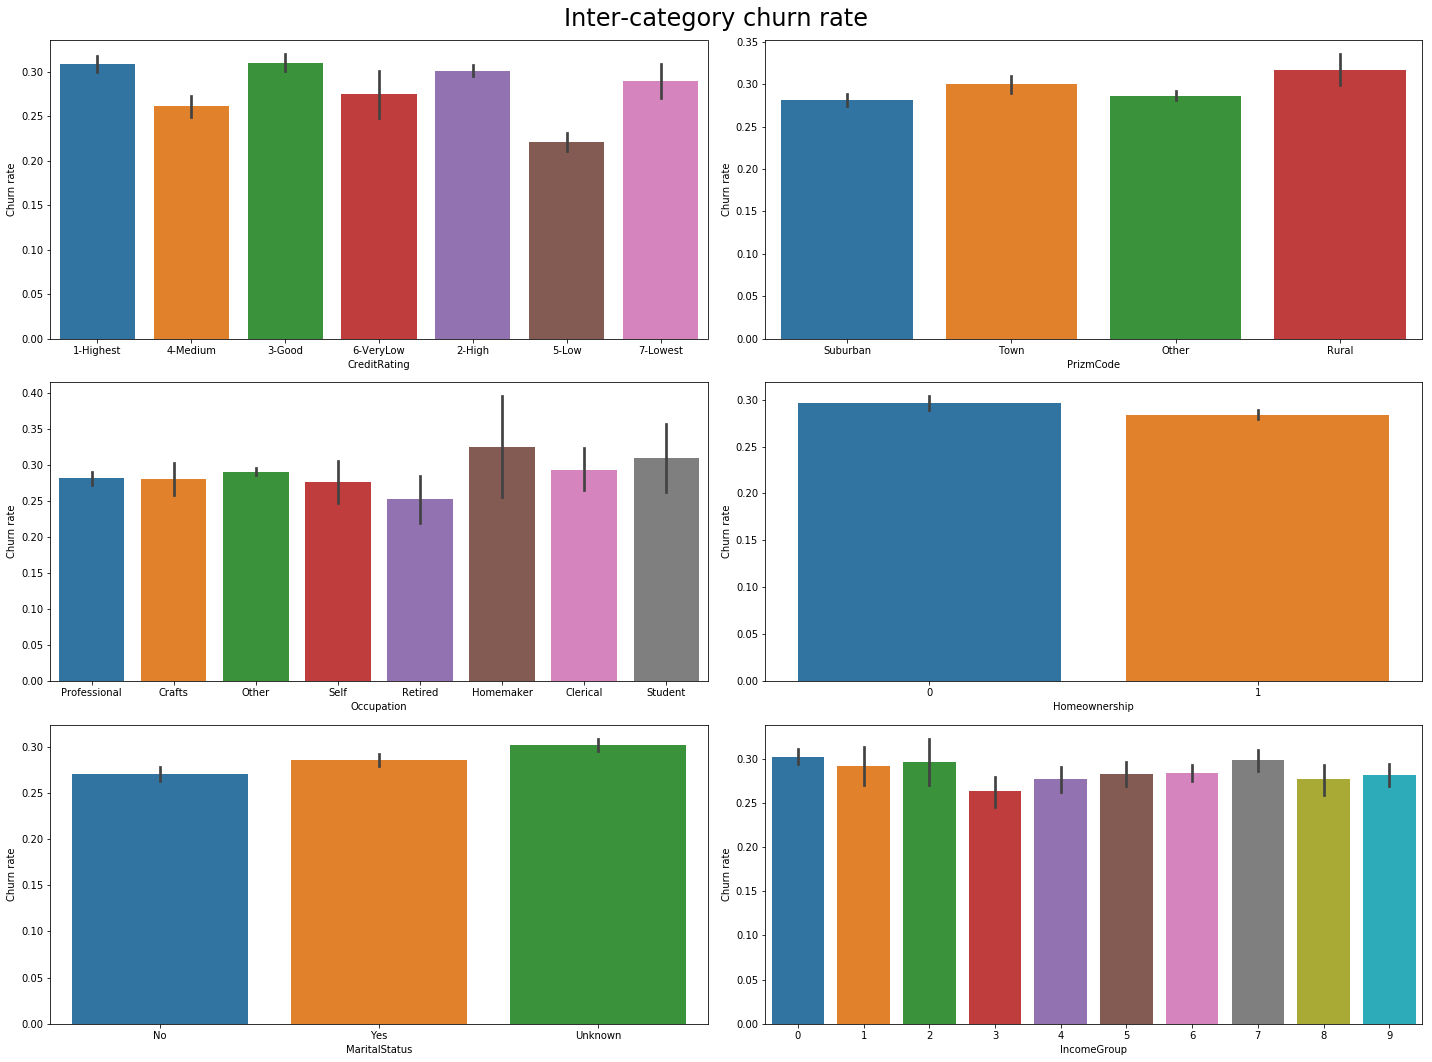

In [21]:
fig = plt.figure(figsize = (20, 15))
j = 1
for c_column in categorical_columns: 
    if c_column != 'ServiceArea': # we treat ServiceArea separately
        plt.subplot(3, 2, j)
        j += 1
        sns.barplot(x=c_column, y='Churn', data=df[categorical_columns+['Churn']]) 
        plt.ylabel('Churn rate')
        
fig.suptitle('Inter-category churn rate', fontsize=24)
fig.tight_layout()
fig.subplots_adjust(top=0.95)
plt.show()

Some observations from the inter-category churn plot: 

- We can see differences in churn in credit rating, which is not surprising. High credit rating means higher churn rate, which can be explained by customers with high credit rating having an easier time negotiating new, better contracts elsewhere. Interestingly, the lowest credit rating bin also has a high churn rate. This might be involuntary churn, which we shouldn't capture with a retention campaign. However, without more information on the underlying customer data set we can't make this decision here. 
- We can see slight differences in location, with rural customers having a slightly higher churn rate, but the difference is very small. 
- We can see differences in occupation, with students having a high churn rate, and retirees the lowest. This matches intuitive understanding of churn behavior. 
- We see almost no difference in churn regarding homeowndership
- We see a very small difference in churn mariatal status, and we have high number of unknowns. 
- We see some difference in the income groups. Without knowing what the bins mean we cannot interpret these however. 

Based on these observations, we discard MaritalStatus, Homeownership, and Prizmcode from the data. Out of all categorical columns we expect CreditRating to have the biggest impact, which matches intuitive understanding. 

In [22]:
for d in ['MaritalStatus', 'Homeownership', 'PrizmCode']: 
    if d not in drop_candidates: 
        drop_candidates.append(d)

#### ServiceArea

It is reasonable that service area has some predictive power regarding churn. There might be bad coverage areas where competitor products have become more compelling. 

However, there is a huge number of service areas in the dataset, and encoding them would explode our dimensionality, adding over 700 dimensions, if we would encode service area into features.

In [23]:
df['ServiceArea'].unique().shape

(748,)

Let's see if we can reduce or remove service area. We look at service areas and churn behavior in more depth. We filter out very small service areas where we have less than 100 subscribers, then plot the churn rate as done for categoricals above. We also plot the size of the service area to compare the churn rate against importance of the area. 

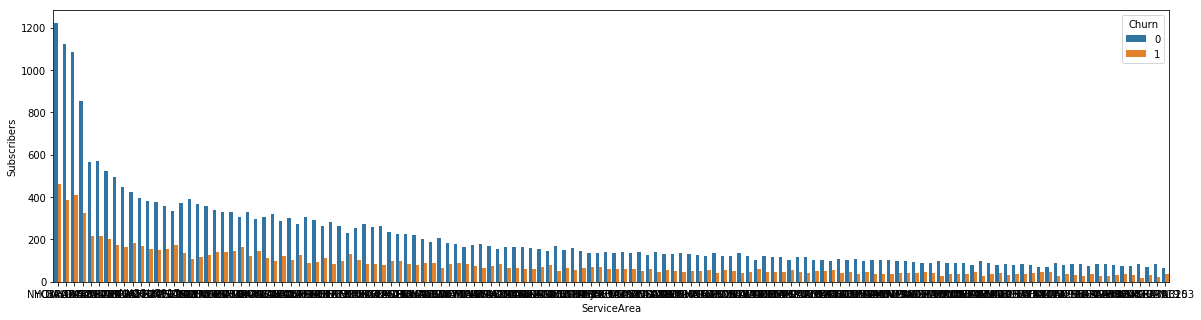

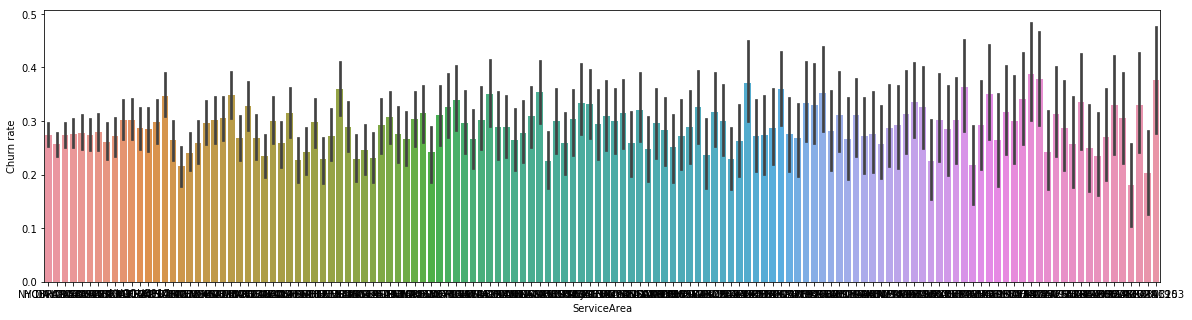

In [24]:
s = df['ServiceArea'].value_counts()
service_areas = df[df.isin(s.index[s > 100]).values]

order = service_areas['ServiceArea'].value_counts().index

fig, ax = plt.subplots(figsize=(20, 5))
sns.countplot(x='ServiceArea', data=service_areas, hue='Churn', order=order)
plt.ylabel('Subscribers')
plt.show()

fig, ax = plt.subplots(figsize=(20, 5))
sns.barplot(x='ServiceArea', y='Churn', data=service_areas, order=order) 
plt.ylabel('Churn rate')
plt.show()

The more subscribers a service area has, the more stable the churn rate, and the closer it is to overall churn rate of the dataset. Only where the areas are very small (just above the 100 subscriber threshold analyzed) do we see larger variations in churn rate. These small number of samples are not expected to generalize well however. 

Service area is not considered worth the explosion in dimensionality, and we drop it. 

In [25]:
if 'ServiceArea' not in drop_candidates:
    drop_candidates.append('ServiceArea')

#### Customer ID 

A unique customer ID has no predictive power as it cannot generalize to new records. Worse, being a running number, it would likely be misinterpreted as a continuous feature. 

Confirm that customer IDs are unique. Add them to the list of columns to be dropped. 

In [26]:
df['CustomerID'].unique().shape[0] == df.shape[0]

True

In [27]:
drop_candidates.append('CustomerID')

Drop the columns we decided to exclude after initial analysis, and make sure they are not included in further processing of categorical and binary columns. 

In [28]:
df_dropped = df.drop(drop_candidates, axis=1)

categorical_columns, binary_columns, continuous_columns, outlier_candidates = drop_from(
    categorical_columns, binary_columns, continuous_columns, outlier_candidates, drop_candidates)

### List and visualize continuous variables

Most of our remaining data is in continuous columns. In this section, we will plot the continous features and determine next steps in pre-processing.

Continous columns:  ['MonthlyRevenue', 'MonthlyMinutes', 'TotalRecurringCharge', 'DirectorAssistedCalls', 'OverageMinutes', 'RoamingCalls', 'PercChangeMinutes', 'PercChangeRevenues', 'DroppedCalls', 'BlockedCalls', 'UnansweredCalls', 'CustomerCareCalls', 'ThreewayCalls', 'ReceivedCalls', 'OutboundCalls', 'InboundCalls', 'PeakCallsInOut', 'OffPeakCallsInOut', 'DroppedBlockedCalls', 'CallForwardingCalls', 'CallWaitingCalls', 'MonthsInService', 'UniqueSubs', 'ActiveSubs', 'Handsets', 'HandsetModels', 'CurrentEquipmentDays', 'RetentionCalls', 'RetentionOffersAccepted', 'ReferralsMadeBySubscriber', 'AdjustmentsToCreditRating', 'HandsetPrice']


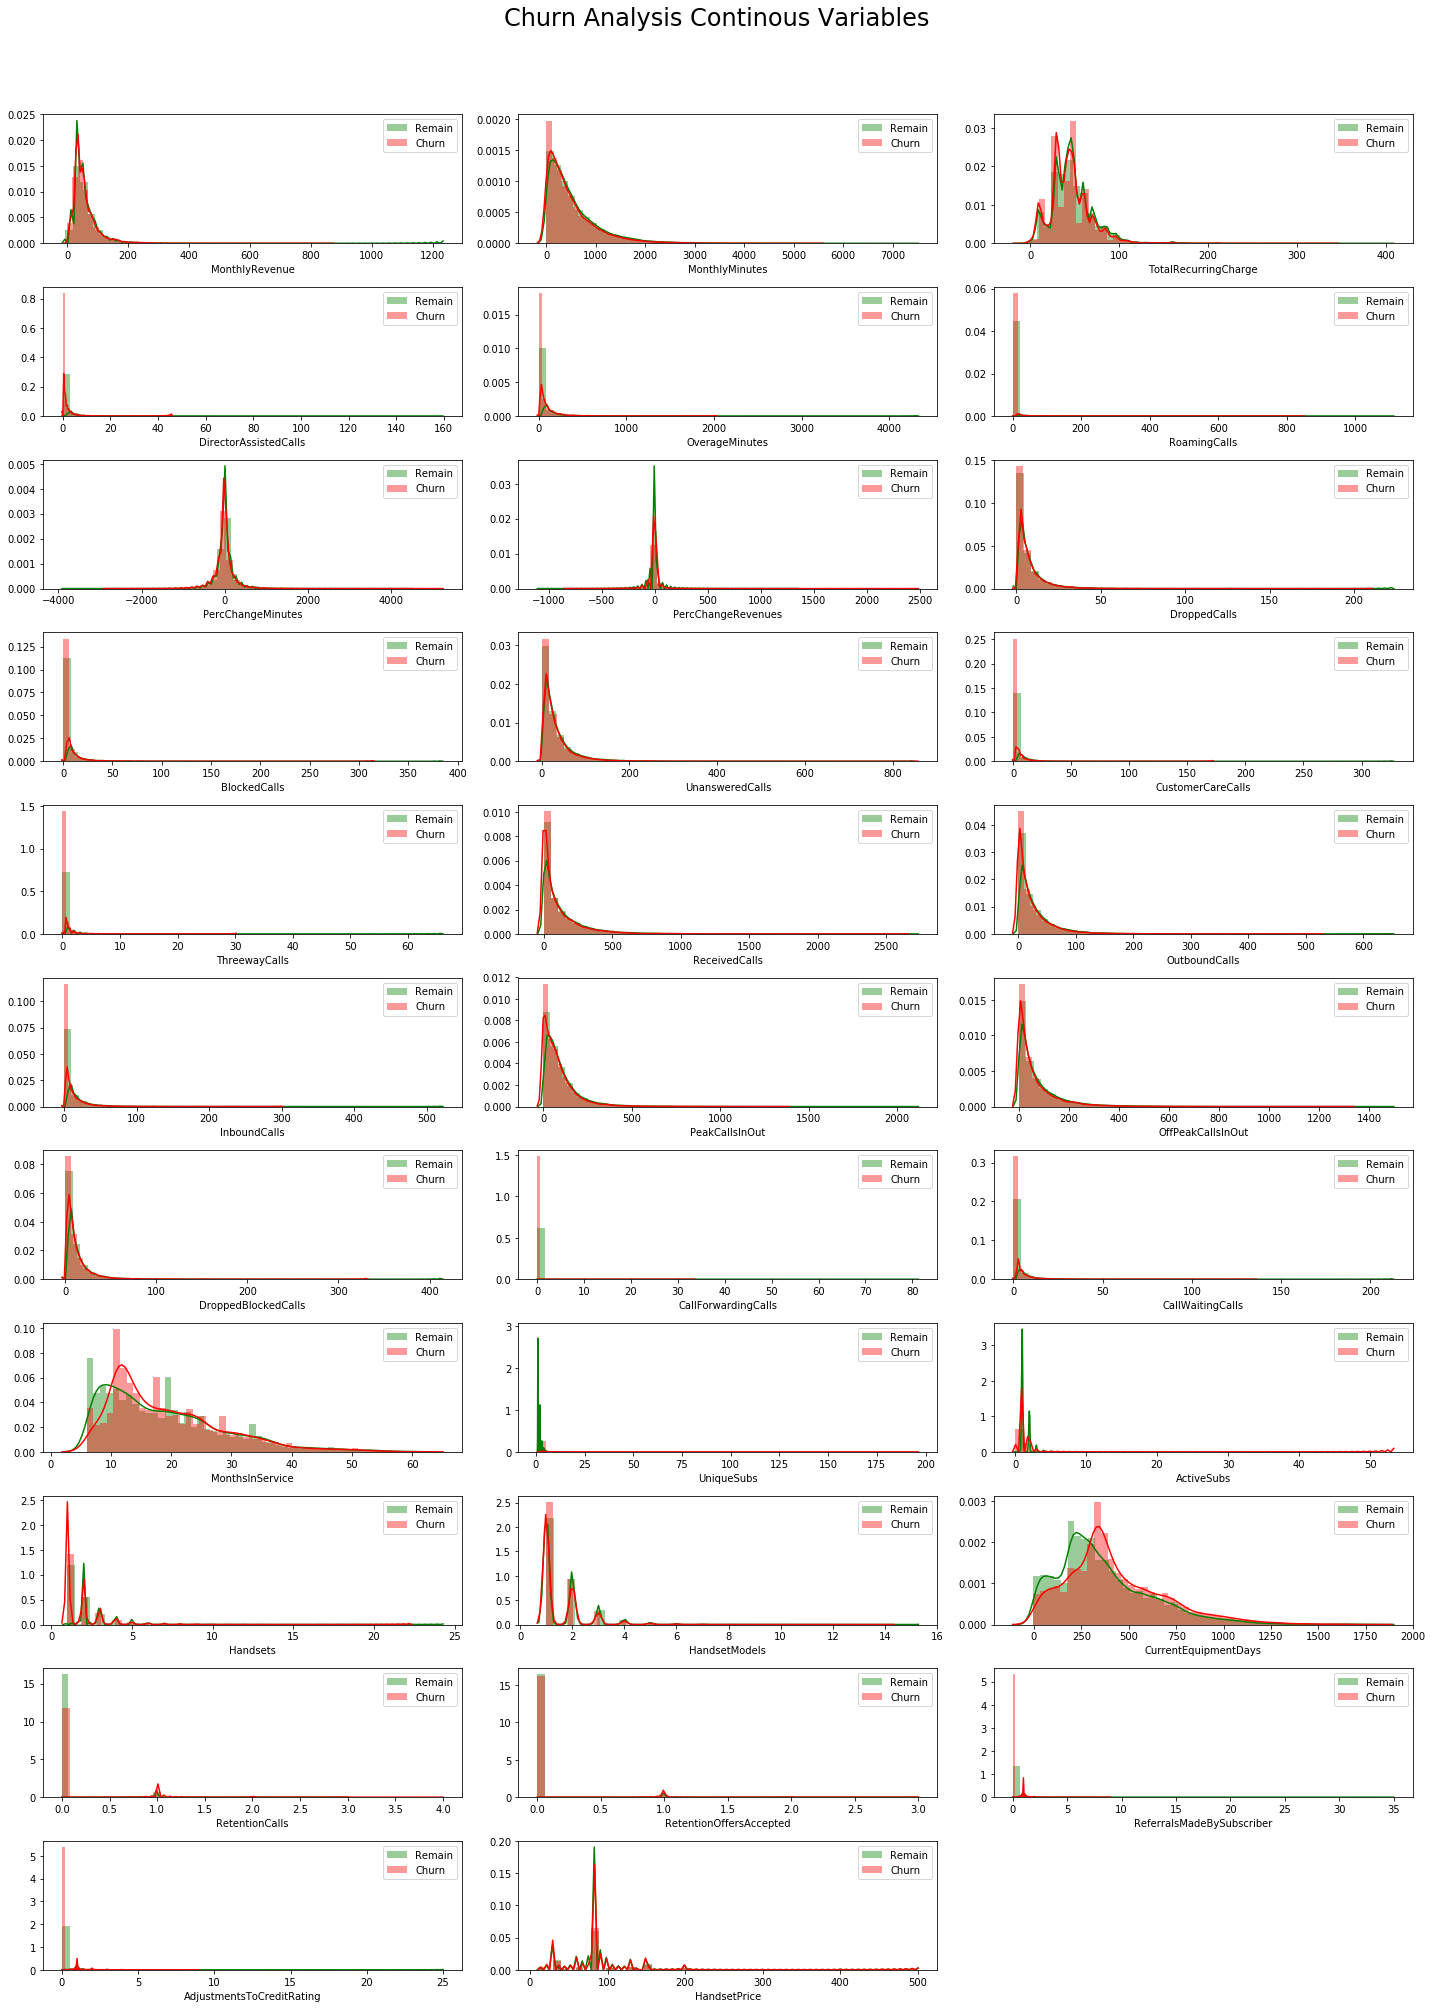

In [29]:
from itertools import chain

continuous_columns = [x for x in df_dropped.columns if x not in chain(binary_columns, categorical_columns, 
                                                                      ['Churn'], drop_candidates)]
print('Continous columns: ', continuous_columns)

fig = plt.figure(figsize = (20, 50))
j = 0
for c_column in continuous_columns:
    plt.subplot(20, 3, j+1)
    j += 1
    sns.distplot(df_dropped[c_column][df_dropped['Churn'] == 0], color='g', label = 'Remain')
    sns.distplot(df_dropped[c_column][df_dropped['Churn'] == 1], color='r', label = 'Churn')
    plt.legend(loc='best')
    
fig.suptitle('Churn Analysis Continous Variables', fontsize=24)
fig.tight_layout()
fig.subplots_adjust(top=0.95)
plt.show()

We can make a few observations here: 
* We can see that most continious columns are highly skewed to the right
* A lot of them seem to have a lot of datapoints at zero
* Most features have extreme outliers
* MonthsInService and CurrentEquipment days show nice separations of the churn and remain distributions. This matches intuition as cell contracts are usually for 1 or 2 years (see baseline metric), and a customer with an old handset is more likely to shop for a new contract. 
* For most columns, skew and zero-inflation is too high to make out a separation of churn and remain. We will need to process these further.

One column where we can deal with zeroes is HandsetPrice. According to the dataset description in V. Umayaparvathi, K. Iyakutt a HandsetPrice of 0 means missing data on Handsets. We replace 0 price for handsets with the mean of handset price.

In [30]:
df_dropped['HandsetPrice'] = df_dropped['HandsetPrice'].replace(0, df_dropped['HandsetPrice'].mean())

df_unknowns = df_dropped.copy()

### Outlier removal

Some of the features' distributions show outliers. Examples are CallForwardingCalls, ActiveSubs, or RoamingCalls. We are going to remove the outliers by cutting off values outside of 3* standard deviation, per column. 

First we plot boxplots of the outlier candidates to show the quartiles of each column, and point lying outside of that. Based on this we want to get an idea of where we might cut off outliers to balance cleaning vs losing too many datapoints. 

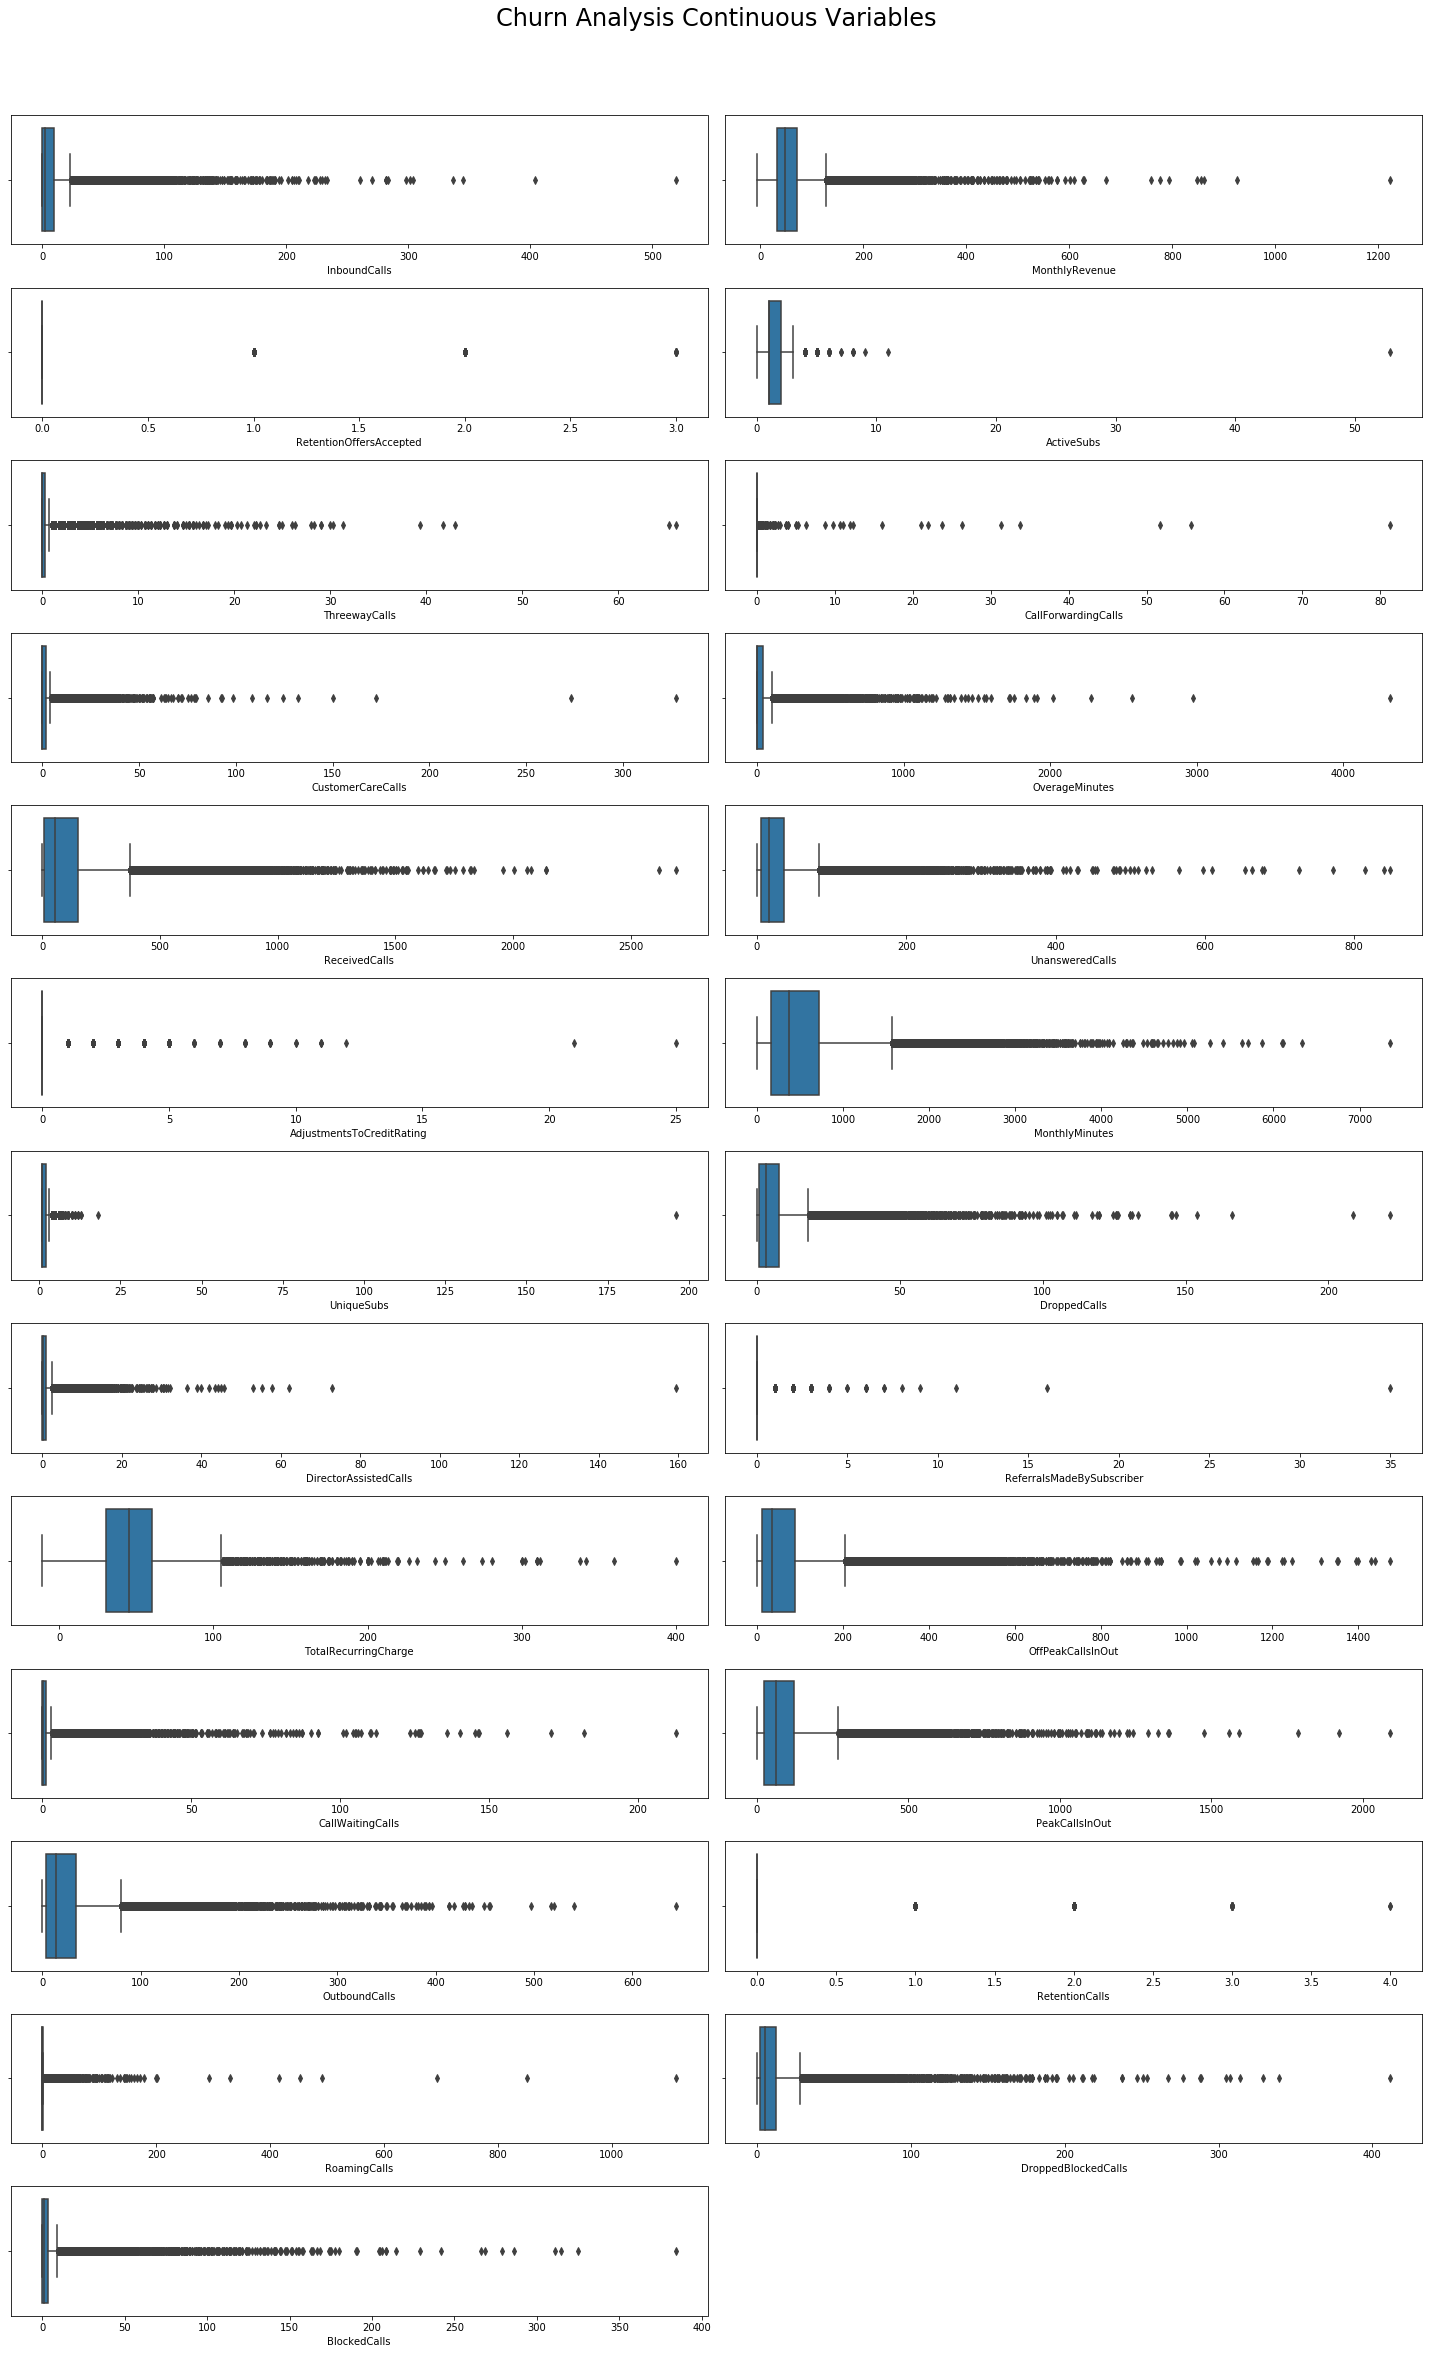

In [31]:
outlier_candidates = ['DirectorAssistedCalls', 'OverageMinutes', 'RoamingCalls', 'DroppedCalls', 'BlockedCalls', 
                      'UnansweredCalls', 'CustomerCareCalls', 'ThreewayCalls', 'ReceivedCalls', 'OutboundCalls', 
                      'InboundCalls', 'PeakCallsInOut', 'OffPeakCallsInOut', 'DroppedBlockedCalls', 
                      'CallForwardingCalls', 'CallWaitingCalls', 'UniqueSubs', 'ActiveSubs', 'RetentionCalls', 
                      'ReferralsMadeBySubscriber', 'AdjustmentsToCreditRating', 'TotalRecurringCharge', 
                      'MonthlyMinutes', 'MonthlyRevenue', 'RetentionOffersAccepted' ]
categorical_columns, binary_columns, continuous_columns, outlier_candidates = drop_from(
    categorical_columns, binary_columns, continuous_columns, outlier_candidates, drop_candidates)

fig = plt.figure(figsize = (20, 50))
j = 0
for o_column in outlier_candidates: 
    plt.subplot(20, 2, j+1)
    j += 1
    sns.boxplot(x=df_unknowns[o_column])

fig.suptitle('Churn Analysis Continuous Variables', fontsize=24)
fig.tight_layout()
fig.subplots_adjust(top=0.95)
plt.show()

**Feature engineering**

We simplify some of the continuous, descrete features to binary features, where the vast majority of samples are either 0 or 1. 

In [32]:
print('Subscribers having made a referral',
      df_unknowns['ReferralsMadeBySubscriber'][df_unknowns['ReferralsMadeBySubscriber'] > 0].count())
print('Subscribers having made more than one referral',
    df_unknowns['ReferralsMadeBySubscriber'][df_unknowns['ReferralsMadeBySubscriber'] > 1].count())
print('Subscribers received a retention call',
      df_unknowns['RetentionCalls'][df_unknowns['RetentionCalls'] > 0].count())
print('Subscribers received more than one retention call',
    df_unknowns['RetentionCalls'][df_unknowns['RetentionCalls'] > 1].count())
print('Subscribers accepted retention offer',
      df_unknowns['RetentionOffersAccepted'][df_unknowns['RetentionOffersAccepted'] > 0].count())
print('Subscribers accepted more than one retention offer',
    df_unknowns['RetentionOffersAccepted'][df_unknowns['RetentionOffersAccepted'] > 1].count())

Subscribers having made a referral 2384
Subscribers having made more than one referral 140
Subscribers received a retention call 1745
Subscribers received more than one retention call 136
Subscribers accepted retention offer 881
Subscribers accepted more than one retention offer 44


In [33]:
# turn the two columns into binary columns, effectively clipping the ˜140 outliers
for r in ['RetentionCalls', 'ReferralsMadeBySubscriber', 'RetentionOffersAccepted']: 
    df_unknowns[r] = df_unknowns[r].clip(upper=1)
    binary_columns.append(r)
    continuous_columns.remove(r)
    if r in outlier_candidates: 
        outlier_candidates.remove(r)

### Extreme outliers

There are some extreme outliers in a number columns. After visual inspection of the pair plots and the interquartile ranges above, and after confirmation that a small number of records are affected, let's remove them. 

We show outliers defined by 3* interquartile range on the log-transformed candidate columns. 

In [34]:
from scipy import stats

print('Number of records outside of 3x interquartile range:\n')
log_data = np.log1p(df_unknowns[outlier_candidates])
for c in outlier_candidates: 
    print(c, log_data[log_data[c] > stats.iqr(log_data[c])*3].shape[0])

Number of records outside of 3x interquartile range:

InboundCalls 0
MonthlyRevenue 0
ActiveSubs 2518
ThreewayCalls 3234
CallForwardingCalls 234
CustomerCareCalls 713
OverageMinutes 0
ReceivedCalls 0
UnansweredCalls 316
AdjustmentsToCreditRating 1838
MonthlyMinutes 43151
UniqueSubs 5086
DroppedCalls 8
DirectorAssistedCalls 1037
TotalRecurringCharge 0
OffPeakCallsInOut 596
CallWaitingCalls 1698
PeakCallsInOut 11328
OutboundCalls 2
RoamingCalls 7388
DroppedBlockedCalls 143
BlockedCalls 106


/home/mes/anaconda3/envs/quadcop/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log1p
  after removing the cwd from sys.path.
/home/mes/anaconda3/envs/quadcop/lib/python3.6/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


Finally, based on the boxplots and pairplots above we identify cutoff points for extreme outliers. 

In [35]:
visually_inspected_outliers = {
    'UniqueSubs': 10, 
    'ActiveSubs': 5,
    'OffPeakCallsInOut': 800, 
    'PeakCallsInOut': 1000,
    'OverageMinutes': 1000,
    'RoamingCalls': 200,
    'DroppedCalls': 100,
    'BlockedCalls': 100,
    'ReceivedCalls': 1500,
    'UnansweredCalls': 500,
    'CustomerCareCalls': 100,
    'ReceivedCalls': 1800,
    'OutboundCalls': 500,
    'InboundCalls': 250,    
    'DroppedBlockedCalls': 250,
    'AdjustmentsToCreditRating': 10, 
    'TotalRecurringCharge': 200, 
    'MonthlyMinutes': 4500,
    'MonthlyRevenue': 600
}

# Since much of EDA is iterative work, we might have looked at outliers that we later decided
# to drop from the data altogether. Filter the list of outliers inspected by our drop candidates
for drop_item in drop_candidates: 
    if drop_item in visually_inspected_outliers:
        visually_inspected_outliers.pop(drop_item)

print('\nOutliers to be removed after visual inspection:\n')
for v_column, threshold in visually_inspected_outliers.items(): 
    print('Outliers to be removed from column {} : {}'.format(
        v_column, df_unknowns[df_unknowns[v_column] > threshold].shape[0]))


Outliers to be removed after visual inspection:

Outliers to be removed from column UniqueSubs : 10
Outliers to be removed from column ActiveSubs : 23
Outliers to be removed from column OffPeakCallsInOut : 45
Outliers to be removed from column PeakCallsInOut : 39
Outliers to be removed from column OverageMinutes : 56
Outliers to be removed from column RoamingCalls : 9
Outliers to be removed from column DroppedCalls : 30
Outliers to be removed from column BlockedCalls : 117
Outliers to be removed from column ReceivedCalls : 11
Outliers to be removed from column UnansweredCalls : 16
Outliers to be removed from column CustomerCareCalls : 8
Outliers to be removed from column OutboundCalls : 4
Outliers to be removed from column InboundCalls : 13
Outliers to be removed from column DroppedBlockedCalls : 12
Outliers to be removed from column AdjustmentsToCreditRating : 6
Outliers to be removed from column TotalRecurringCharge : 42
Outliers to be removed from column MonthlyMinutes : 25
Outlier

Let's recalculate and show the outliers according to 3x IQR again: 

In [36]:
for v_column, threshold in visually_inspected_outliers.items(): 
    df_unknowns = df_unknowns[df_unknowns[v_column] <= threshold]
    
df_outliers = df_unknowns.copy()

print('Number of records outside of 3x interquartile range, after removing extreme outliers:\n')
log_data = np.log1p(df_outliers[outlier_candidates])
for c in outlier_candidates: 
    print(c, log_data[log_data[c] > stats.iqr(log_data[c])*3].shape[0])

Number of records outside of 3x interquartile range, after removing extreme outliers:



/home/mes/anaconda3/envs/quadcop/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log1p
  import sys


InboundCalls 0
MonthlyRevenue 0
ActiveSubs 2475
ThreewayCalls 3069
CallForwardingCalls 228
CustomerCareCalls 668
OverageMinutes 0
ReceivedCalls 0
UnansweredCalls 156
AdjustmentsToCreditRating 1802
MonthlyMinutes 43005
UniqueSubs 5021
DroppedCalls 0
DirectorAssistedCalls 1333
TotalRecurringCharge 0
OffPeakCallsInOut 427
CallWaitingCalls 1528
PeakCallsInOut 11078
OutboundCalls 0
RoamingCalls 7283
DroppedBlockedCalls 17
BlockedCalls 0


There are a lot of outliers in the two percentage change columns that look like errors, for example where PercentageChangeMinutes equals MonthlyMinutes, or where MonthlyMinutes is very small, but PercentageChangeMinutes is in the hundreds. 

For PercChangeRevenues these cases are rare enough that we simply clip the value to 250% change, up or down.

In [37]:
df_outliers.loc[:,'PercChangeRevenues'] = df_outliers['PercChangeRevenues'].clip(-250, 250)
df_outliers.loc[:,'PercChangeMinutes'] = df_outliers['PercChangeMinutes'].clip(-1000, 1000)

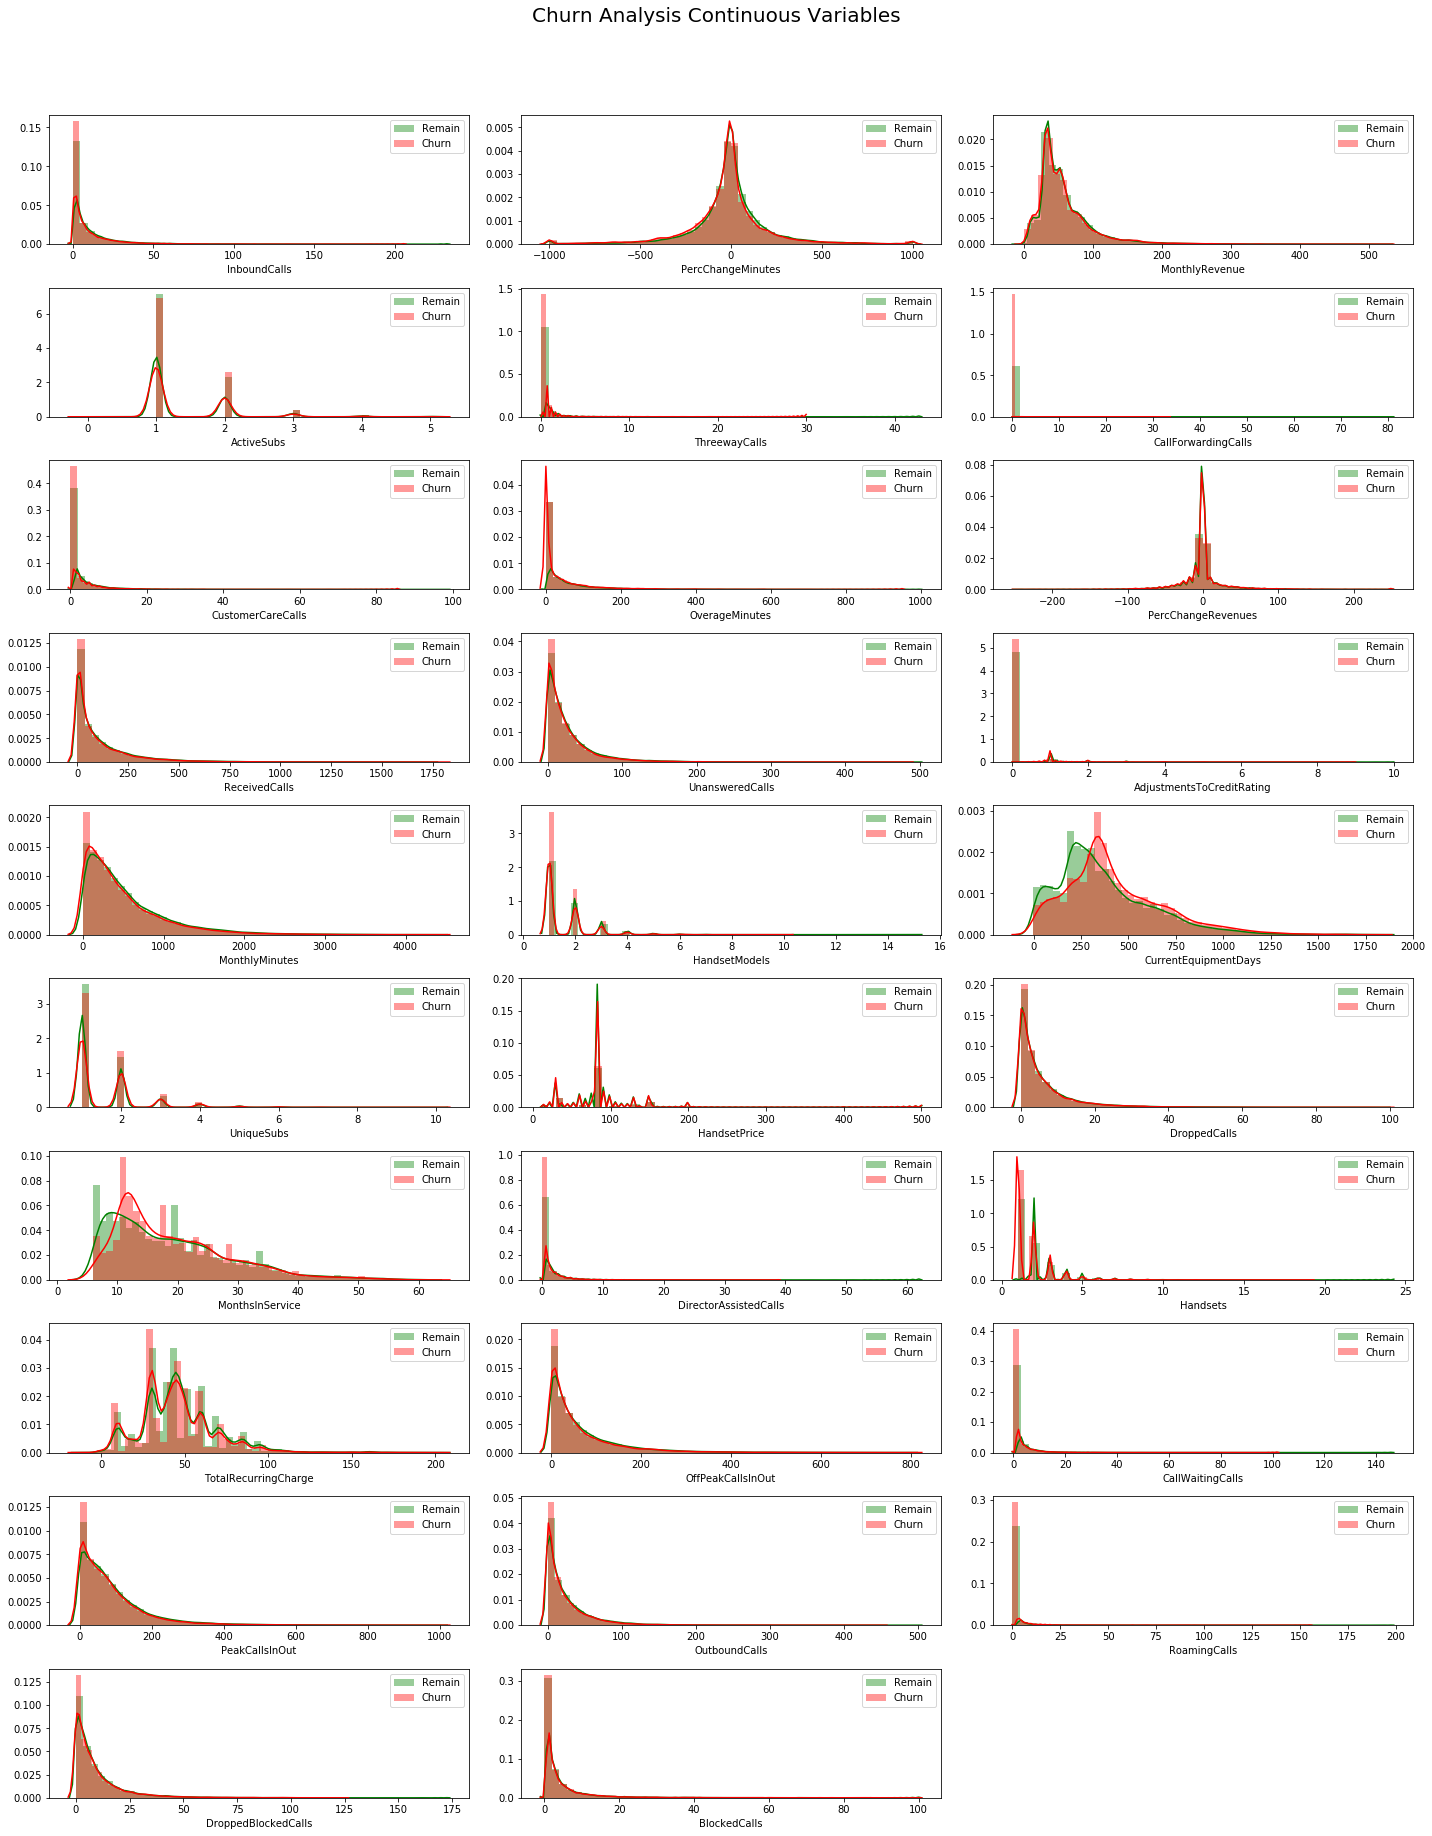

In [38]:
fig = plt.figure(figsize = (20, 50))
j = 0
for c_column in continuous_columns:
    plt.subplot(20, 3, j+1)
    j += 1
    sns.distplot(df_outliers[c_column][df_outliers['Churn'] == 0], color='g', label = 'Remain')
    sns.distplot(df_outliers[c_column][df_outliers['Churn'] == 1], color='r', label = 'Churn')
    plt.legend(loc='best')
    
fig.suptitle('Churn Analysis Continuous Variables', fontsize=20)
fig.tight_layout()
fig.subplots_adjust(top=0.95)
plt.show()

### Log transform

To bring the remaining columns into a more equal, normal shape, we identify columns we can log-transform to reduce the skew in the data. This will work best for all the call-related columns, as they are all positive or zero. We use log1p() to safely transform columns that might include zeroes. 

In [39]:
log_transform_candidates = ['MonthlyMinutes', 'OverageMinutes', 
                            'RoamingCalls', 'DroppedCalls', 'BlockedCalls', 'UnansweredCalls',
                            'CustomerCareCalls', 'ReceivedCalls', 'OutboundCalls', 'InboundCalls',
                            'PeakCallsInOut', 'OffPeakCallsInOut', 'DroppedBlockedCalls',
                            'CallForwardingCalls', 'UniqueSubs', 'ActiveSubs', 
                            'AdjustmentsToCreditRating' ]

log_transform_candidates = list(set(log_transform_candidates) - set(drop_candidates))
df_log1p = df_outliers.copy()

df_log1p.loc[:,log_transform_candidates] = np.log1p(df[log_transform_candidates])

# there are (very few, less than 10) records with negative values in these columns. Transform them separately to avoid
# NaN from division by zero on log()
log_transform_with_negatives = ['MonthlyRevenue', 'TotalRecurringCharge']

for n_column in log_transform_with_negatives: 
    df_log1p.loc[:,n_column] = np.log1p(df[n_column]+abs(df[n_column].min()))

After preprocessing of continuous variables, let's plot them again before we continue with encoding categoricals.

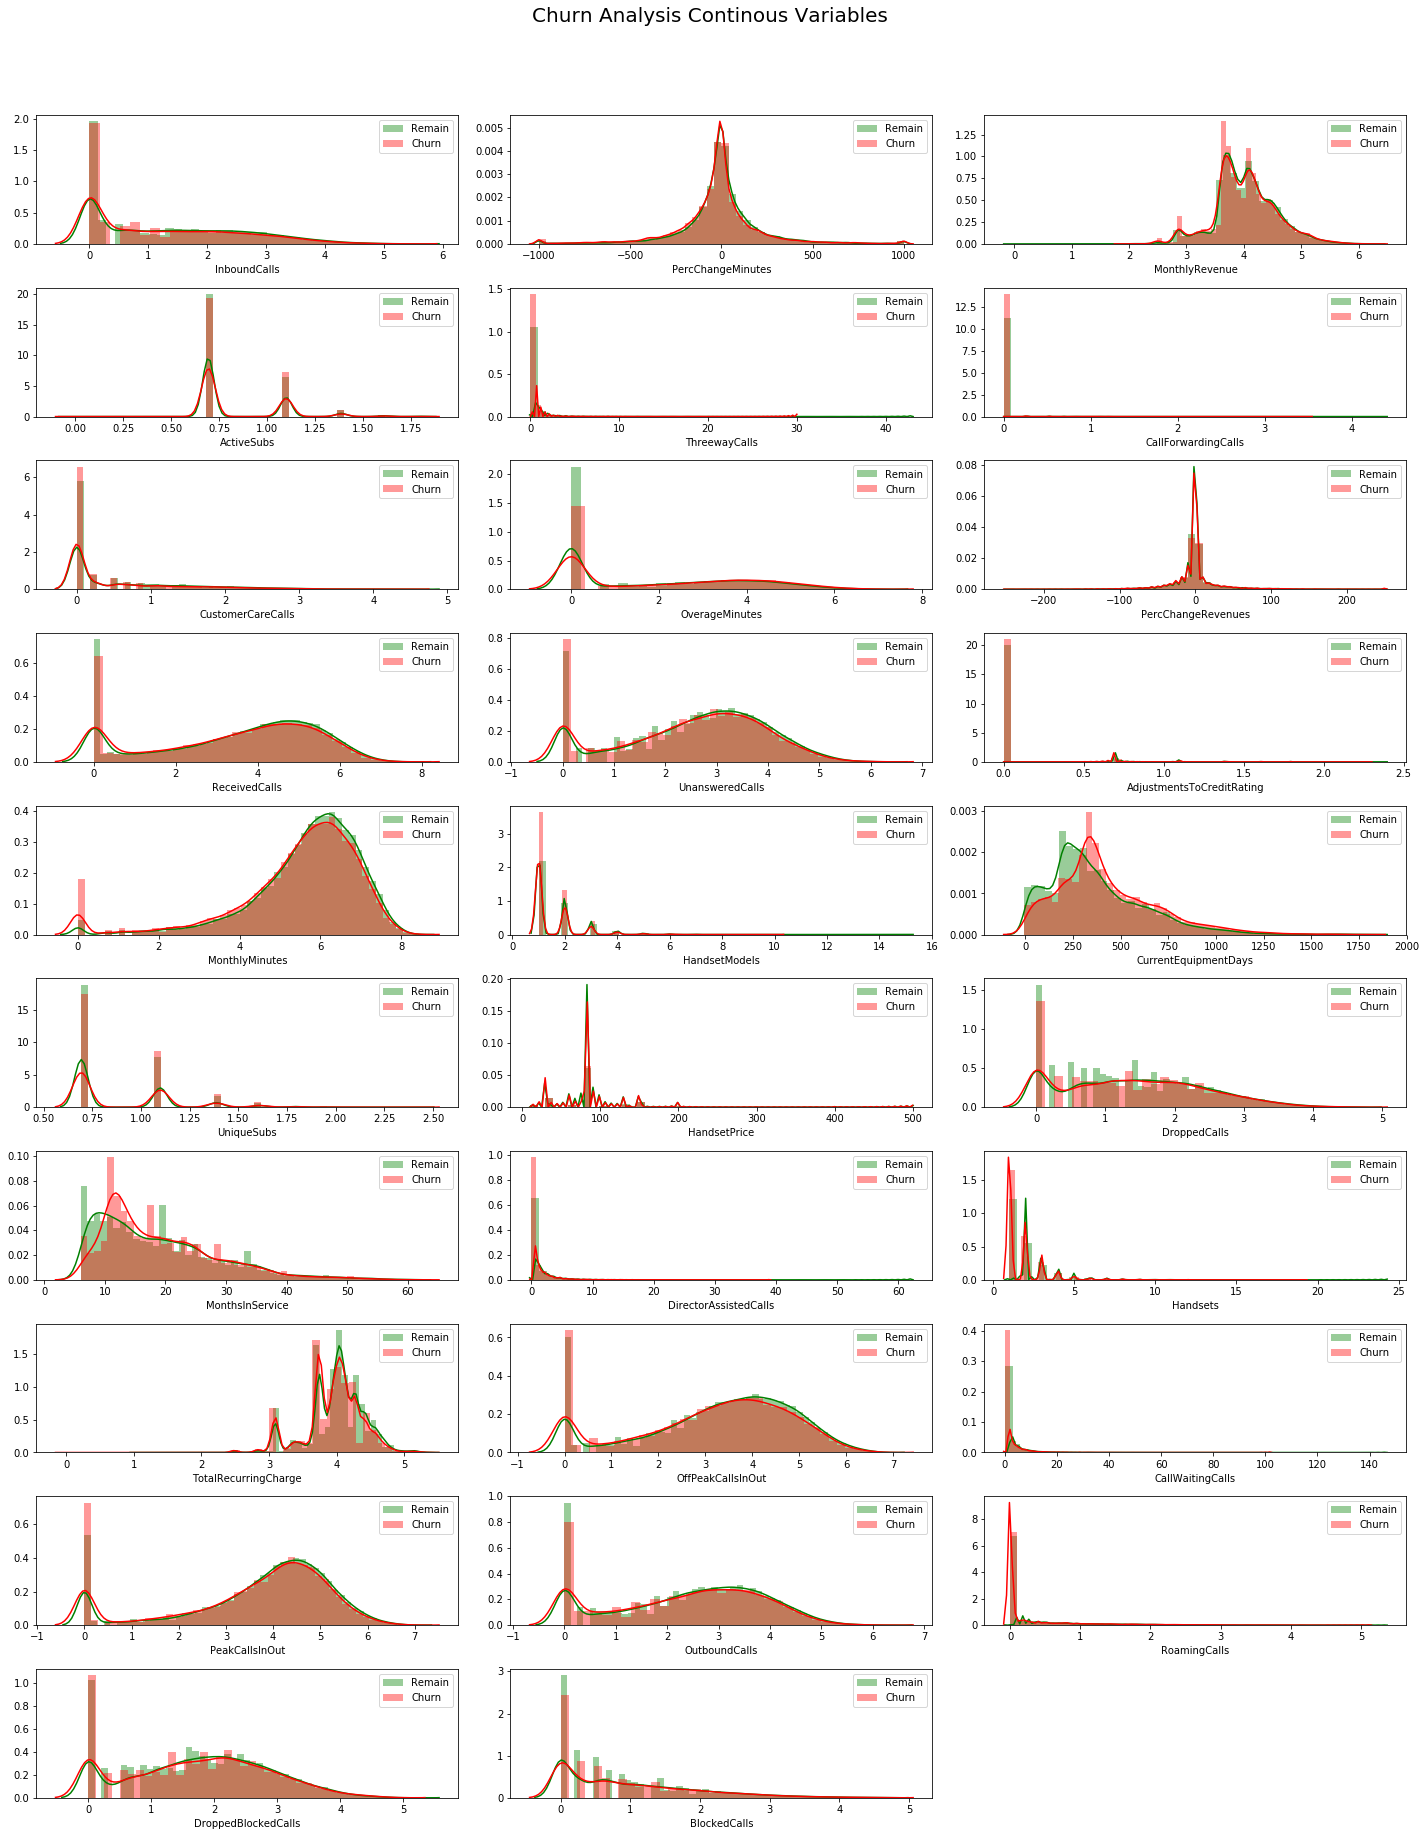

In [40]:
fig = plt.figure(figsize = (20, 50))
j = 0
for c_column in continuous_columns:
    plt.subplot(20, 3, j+1)
    j += 1
    sns.distplot(df_log1p[c_column][df_log1p['Churn'] == 0], color='g', label = 'Remain')
    sns.distplot(df_log1p[c_column][df_log1p['Churn'] == 1], color='r', label = 'Churn')
    plt.legend(loc='best')
    
fig.suptitle('Churn Analysis Continous Variables', fontsize=20)
fig.tight_layout()
fig.subplots_adjust(top=0.95)
plt.show()

We can see that after log-transforming the continuous columns, about half of them show a distribution that makes it possible to see some separation of churners from non-churners. 

A number of column's plots are still virtually vertical at zero, and horizontal over the rest of the distribution. We remove them from the dataset.

Note: this has been approached iteravily: We remove columns that show extreme density near 0, very low importance in classification algorithms that state importance, and where intuition would suggest the column shouldn't contribute much to the classification. Also, when oversampling was tried, these columns seemed to contribute to a lot of noise added to the data. 

In [41]:
drop_log1p_extremes = ['AdjustmentsToCreditRating', 'CallForwardingCalls', 'ThreewayCalls', 'BlockedCalls',
                       'DirectorAssistedCalls', 'Handsets', 'CallWaitingCalls', 'ActiveSubs', 'UniqueSubs']

df_log1p_removed = df_log1p.drop(drop_log1p_extremes, axis=1)

categorical_columns, binary_columns, continuous_columns, outlier_candidates = drop_from(
    categorical_columns, binary_columns, continuous_columns, outlier_candidates, drop_log1p_extremes)

*Note: The following cell is not required for running the solution, but is used to inspect and compare individual numerical features more closely.*

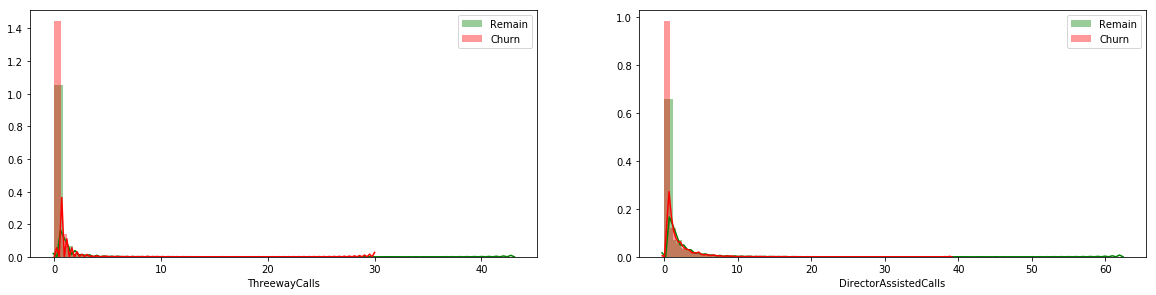

In [42]:
fig = plt.figure(figsize = (20, 10))

c_column = 'OutboundCalls'
c_column = 'MonthsInService'
c_column = 'TotalRecurringCharge'
c_column = 'UnansweredCalls'
c_column = 'ThreewayCalls'
plt.subplot(2, 2, 1)
sns.distplot(df_outliers[c_column][df_outliers['Churn'] == 0], color='g', label = 'Remain')
sns.distplot(df_outliers[c_column][df_outliers['Churn'] == 1], color='r', label = 'Churn')
plt.legend(loc='best')

c_column = 'CurrentEquipmentDays'
c_column = 'MonthlyRevenue'
c_column = 'DroppedCalls'
c_column = 'DirectorAssistedCalls'
plt.subplot(2, 2, 2)
sns.distplot(df_outliers[c_column][df_outliers['Churn'] == 0], color='g', label = 'Remain')
sns.distplot(df_outliers[c_column][df_outliers['Churn'] == 1], color='r', label = 'Churn')
#sns.distplot(df_log1p[c_column][df_log1p['Churn'] == 0], color='g', label = 'Remain')
#sns.distplot(df_log1p[c_column][df_log1p['Churn'] == 1], color='r', label = 'Churn')
plt.legend(loc='best')
plt.show()

### Further processing

The first few iterations of training decision tree based classifiers (RF, XGB) revealed that 
* Across XGB and RF, a lot of features are not considered important for classification. 
* The categorical columns IncomeGroup, Occupation, CreditRating are barely used by both classifiers. 

Below two plots show the feature importance, frozen from earlier iterations. Based on these the 3 mentioned features have also been removed from the data.
 
![](images/featureimportance_rf_pass1.png)
![](images/featureimportance_xgb_pass1.png)

Based on these importance plots from previous iterations we also exclude the mentioned columns from the dataset. 

In [43]:
drop_low_importance = ['IncomeGroup', 'Occupation', 'CreditRating', 'ReferralsMadeBySubscriber']

categorical_columns, binary_columns, continuous_columns, outlier_candidates = drop_from(
    categorical_columns, binary_columns, continuous_columns, outlier_candidates, drop_low_importance)

df_importance = df_log1p_removed.drop(drop_low_importance, axis=1)

Finally, we have our final dataset to be used for training and prediction. 

In [44]:
df_final = df_importance.copy()

print(df_final.shape)

df_final.sample(5).transpose()

(50695, 24)


,43114,5621,12345,1666,19897
Churn,0.000000,1.000000,0.000000,0.000000,0.000000
MonthlyRevenue,4.802709,3.996915,4.867150,3.649099,4.196299
MonthlyMinutes,6.933423,5.634790,6.673298,5.693732,5.493061
TotalRecurringCharge,4.644391,3.850148,3.912023,3.737670,4.127134
OverageMinutes,3.332205,2.772589,5.652489,0.000000,0.000000
RoamingCalls,0.000000,1.609438,0.000000,0.000000,2.332144
PercChangeMinutes,285.000000,11.000000,-248.000000,12.000000,54.000000
PercChangeRevenues,-20.300000,-8.700000,-111.400000,-0.200000,-1.700000
DroppedCalls,1.740466,2.079442,2.541602,2.230014,1.791759
UnansweredCalls,4.272491,3.030134,3.563883,2.928524,2.459589


## One-hot encoding

We one-hot encode our categorical columns to make them useable by the classification algorithms. 

In [45]:
df_final_dummies = pd.get_dummies(df_final, columns=categorical_columns)

## Train-test split

We split the data into training set and test set for both features and labels. 

In [46]:
X = df_final_dummies.drop(columns='Churn', axis=1)
y = df_final_dummies['Churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=random_state)

## Resampling

The dataset is imbalanced, which will make typical classification algorithm perform very poorly on our target metric. Deploy resampling of the training set to balance the dataset. 

Try both under- and oversampling the training data and keep the more successful sampling strategy. 

In [47]:
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler

print('Remain/Churn before resampling: ', Counter(y_train))

rus = RandomUnderSampler(random_state=random_state)
X_train_sampled, y_train_sampled = rus.fit_resample(X_train, y_train)

print('Remain/Churn after resampling: ', Counter(y_train_sampled))

Remain/Churn before resampling:  Counter({0: 27059, 1: 10962})
Remain/Churn after resampling:  Counter({0: 10962, 1: 10962})


Undersampling and oversampling as well as oversampling with noise cleanup has been tried. Both oversampling techniques introduces too much error and yielded worse results. This can be explained in part by the still existing wide spread and outliers in the data, which oversampling tends to emphasize. 

We finally work with an undersampled dataset. 

## Feature Scaling

Scale the data to a 0,1 range. Standardscaler, Minmaxscaler, and Robustscaler habe been tried. RobustScaler gives slightly better results. This can be explained by the remaining outliers in the data. As we saw above, even after outlier removal, some features still had a lot of spread. 

In [48]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler

robust_scaler = RobustScaler()
robust_scaler.fit(X_train_sampled)

X_train_sampled = robust_scaler.transform(X_train_sampled)
X_test = robust_scaler.transform(X_test)



# Training 

We define and train the classifiers based on the following algorithms. 

* Logistic Regression
* Random Forest
* XGBoost
* Neural Net (MLP)

First, initialize the classifiers with default parameters. Neural net is treated separately as it needed more extensive implementation than the other classifiers. 

In [49]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.model_selection import cross_val_score, RandomizedSearchCV
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform

clfs = {
    'Logistic Regression': LogisticRegression(solver='lbfgs', random_state=random_state),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=random_state, n_jobs=N_JOBS),     
    'XGBoost': xgb.XGBClassifier(n_estimators=1000, objective='binary:logistic', 
                                 booster='gbtree', random_state=random_state, n_jobs=N_JOBS)
}

## Parameter Search

For the three first classifiers, we perform a randomized search cross validation for hyperparameter tuning. Since this is very performance intensive it can be steered with a parameter. 

In [50]:
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning) 

searchparams = {}

searchparams['Logistic Regression'] = {
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'C': sp_uniform(0,5)
}
searchparams['Random Forest'] = {
    "max_depth": sp_randint(3, 8),
    "max_features": sp_uniform(.1, .9),
    "min_samples_split": [.3,.4,.5,.6,.7,.8],
    "criterion": ["gini", "entropy"]
}
searchparams['XGBoost'] = {
    'eta': [0.01],
    'min_child_weight': sp_uniform(0.5, 1.),
    'max_depth': [3, 4, 5],
    'gamma': [0,1,5,10,15], #sp_uniform(0, 0.1),
    'colsample_bytree': [.3,.4,.5,.6,.7,.8], 
    'subsample': sp_uniform(0.6, .3),
}

if with_param_search: 
    for name, clf in clfs.items(): 
        n_iter_search = 20
        random_search = RandomizedSearchCV(clf, param_distributions=searchparams[name], random_state=random_state,
                                           n_iter=n_iter_search, cv=5, iid=False, n_jobs=1)
        random_search.fit(X_train_sampled, y_train_sampled)
        clfs[name] = random_search.best_estimator_   
        print('--- {} ---'.format(name))
        print(random_search.best_params_)

--- Logistic Regression ---
{'C': 1.8727005942368125, 'solver': 'saga'}
--- Random Forest ---
{'criterion': 'entropy', 'max_depth': 3, 'max_features': 0.14180537144799796, 'min_samples_split': 0.5}
--- XGBoost ---
{'colsample_bytree': 0.5, 'eta': 0.01, 'gamma': 10, 'max_depth': 5, 'min_child_weight': 1.4832308858067882, 'subsample': 0.7400288679743939}


## Model prediction

Next, we fit the tuned models to the data (if not done already during tuning). Then, we collect our predictions on the test set. We report statistics on the predictions in our custom report collector. 

In [51]:
for name, clf in clfs.items():     
    if not with_param_search: 
        clf.fit(X_train_sampled, y_train_sampled)
    metricreport.predict_add(clf, X_test, y_test)
    print(name, 'fbeta', scorer(clf, X_test, y_test), 'accuracy', accuracy_score(y_test, clf.predict(X_test)))

Logistic Regression fbeta 0.4636650167580406 accuracy 0.5949976329493452
Random Forest fbeta 0.5034843036252309 accuracy 0.5460785860817422
XGBoost fbeta 0.5108090914972074 accuracy 0.61204039766451


### Feature importance

For the decision-tree based algorithms, we can output the feature importance. 

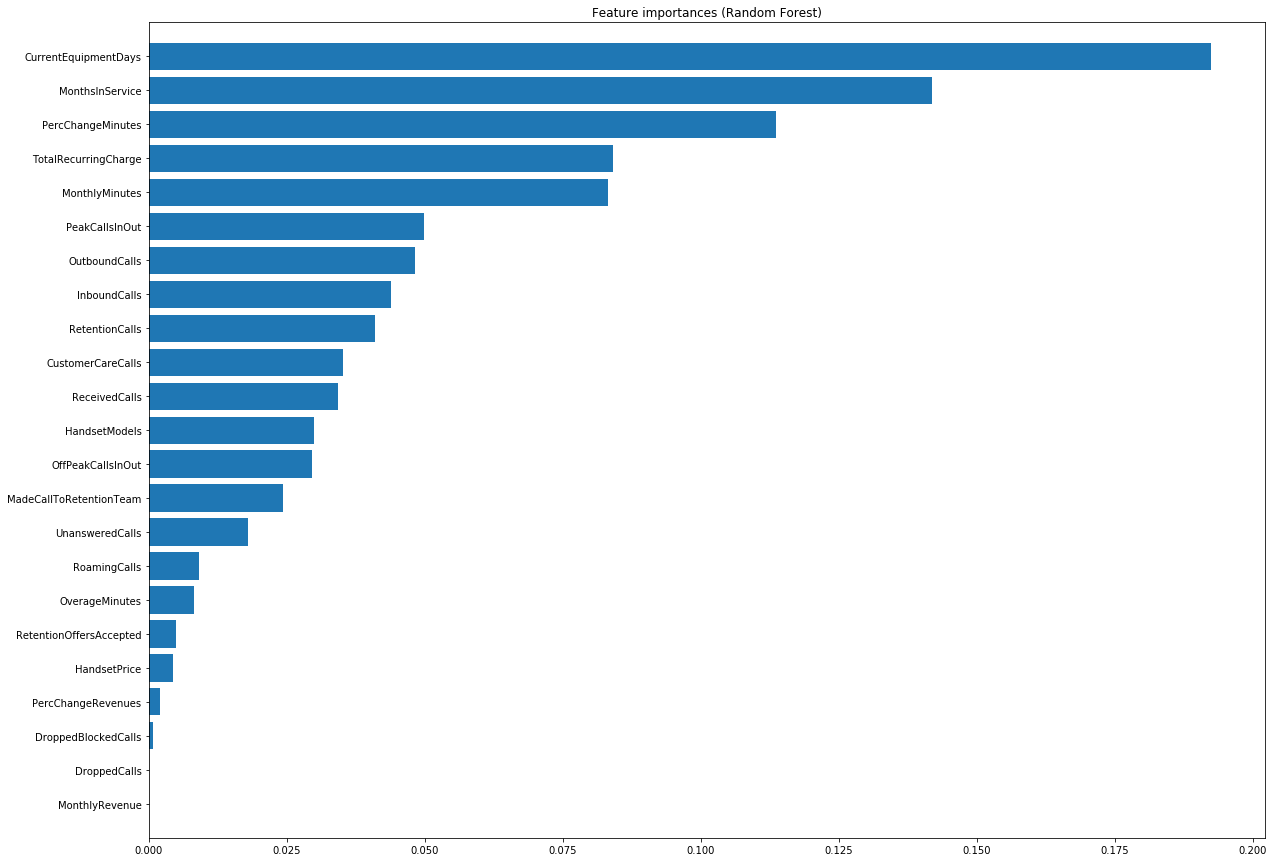

In [52]:
importances = clfs['Random Forest'].feature_importances_
indices = np.argsort(importances)

# Plot the feature importances of the forest
fig = plt.figure(figsize = (20, 15))
plt.title("Feature importances (Random Forest)")
plt.barh(range(X.shape[1]), importances[indices], align="center")
plt.yticks(range(X_train.shape[1]), X.columns[indices])
plt.ylim([-1, X.shape[1]])
plt.show()

The feature importance of our RF classifier seems off. We find columns we expect to have big impact on the result (MonthsInService) far down the line. Also, features IncomeGroup and Occupation don't seem to have been included at all and are just listed alphabetically. 

To check what is going on, let's look at the training curve of the classifier: 

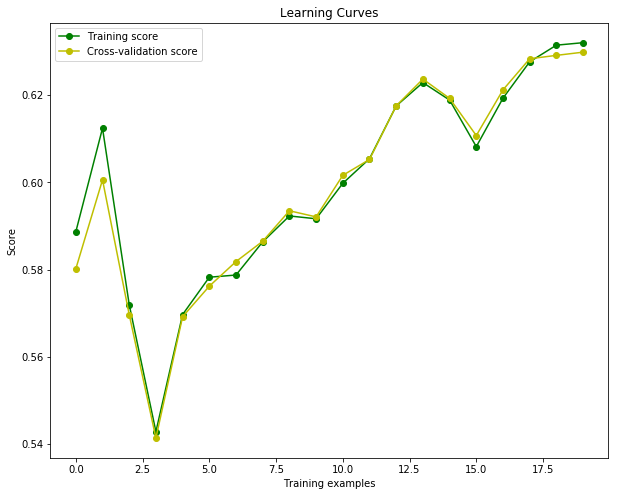

In [53]:
from utils import draw_learning_curves

if with_learning_curves:
    draw_learning_curves(clfs['Random Forest'], X_train_sampled, y_train_sampled, 
                         n_jobs=N_JOBS, random_state=random_state, scoring=scorer)

/home/mes/anaconda3/envs/quadcop/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mes/anaconda3/envs/quadcop/lib/python3.6/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


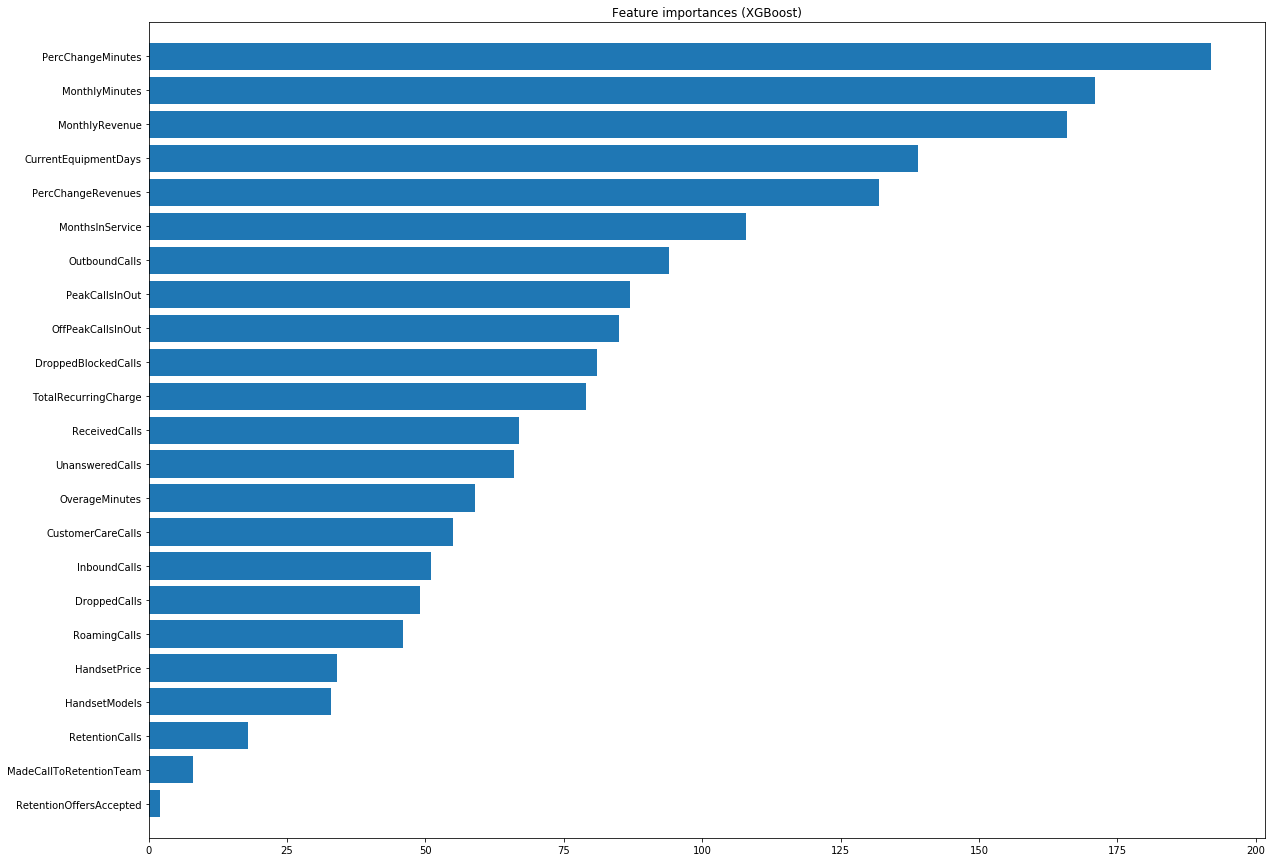

In [54]:
from xgboost import plot_importance

dtrain = xgb.DMatrix( X, label=y)

clfs['XGBoost'].get_booster().get_fscore()
mapper = {'f{0}'.format(i): v for i, v in enumerate(dtrain.feature_names)}
mapped = {mapper[k]: v for k, v in clfs['XGBoost'].get_booster().get_fscore().items()}

sorted_x = sorted(mapped.items(), key=lambda kv: kv[1],reverse=False)

# Plot the feature importances of the forest
fig = plt.figure(figsize = (20, 15))
plt.title("Feature importances (XGBoost)")
plt.barh(range(len(sorted_x)), [x[1] for x in sorted_x], align='center')
plt.yticks(range(len(sorted_x)), [x[0] for x in sorted_x])
plt.ylim([-1, len(sorted_x)])
plt.show()

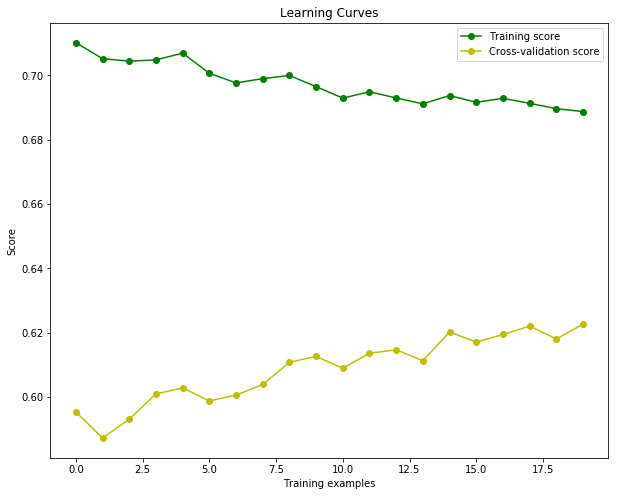

In [55]:
if with_learning_curves:
    # note: XGBoost jobs get killed likely becuase it has its own parallelization so
    # we have to forgo parallel processing here 
    draw_learning_curves(clfs['XGBoost'], X_train_sampled, y_train_sampled, 
                         n_jobs=1, random_state=random_state, scoring=scorer)

As a comparison, here is the learning curve of logistic regression

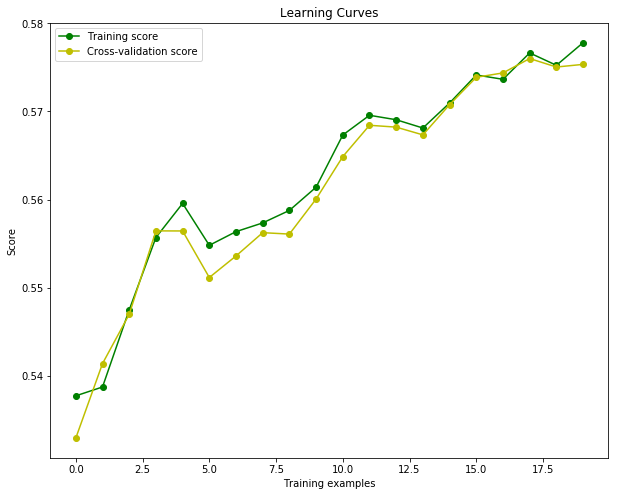

In [56]:
if with_learning_curves:
    draw_learning_curves(clfs['Logistic Regression'], X_train_sampled, y_train_sampled, 
                         n_jobs=N_JOBS, random_state=random_state, scoring=scorer)

**Neural net with custom global objective**

As novel approach to training, we try to optimize recall directly instead of optimizing accuray via logloss. For this we make use of experimental model that includes new loss layers called global objectives in tensorflow. 

Since our objective is to keep false negatives low, we will run our neural net classifier with the global objective loss layer recall_at_precision_loss, in an effort to maximize recall directly instead of overall precision. 

The paper on global objectives and the tensorflow loss layers can be found here:

https://arxiv.org/abs/1608.04802
https://github.com/tensorflow/models/tree/master/research/global_objectives


In [57]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

from keras import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.wrappers.scikit_learn import KerasClassifier
from utils import ClassifierMetricsCallback
from keras.callbacks import EarlyStopping
from keras.regularizers import l2, l1_l2
from keras import optimizers
import keras.backend as K
from global_objectives.loss_layers import precision_at_recall_loss
from global_objectives.loss_layers import recall_at_precision_loss
from global_objectives import util
import tensorflow as tf 

util.get_num_labels = lambda labels : 1

BATCH_SIZE = 1000
TARGET_PRECISION = 0.55


def get_recall_at_precision_loss(target_precision):
    '''Custom objective (loss) function
    
    References
    https://arxiv.org/abs/1608.04802
    https://github.com/tensorflow/models/tree/master/research/global_objectives

    '''
    def recall_at_precision_loss_wrapper(y_true, y_pred):
        # from debugging: the loss function is called with a [-1, None] shape 
        # when the model graph is being built. Likely this is because the loss
        # function can accept both binary and multi-class labels, and the 
        # information on the label shape is either lost, or not initialized in a 
        # way the global_objective TF module expects when we call it from the keras API.
        # We reshape to our binary problem in this wrapper function:         
        y_true = K.reshape(y_true, (-1, 1)) 
        y_pred = K.reshape(y_pred, (-1, 1))   
        return recall_at_precision_loss(y_true, y_pred, target_precision)[0]
    return recall_at_precision_loss_wrapper


def make_model(nodes=400, activation='elu', dropout_rate=0.4, lr=0.0005, l2_rate=0.001):
    kernel_regularizer = l2(l2_rate)  
    
    model = Sequential()
    model.add(Dense(nodes, input_dim=X_train_sampled.shape[1], kernel_regularizer=kernel_regularizer))
    model.add(Activation(activation))
    model.add(Dropout(rate=dropout_rate))
    model.add(Dense(nodes, kernel_regularizer=kernel_regularizer))
    model.add(Activation(activation))
    model.add(Dropout(rate=dropout_rate))
    model.add(Dense(1, activation='sigmoid'))
    
    optimizer = optimizers.Adam(lr=lr)
    model.compile(optimizer=optimizer, loss=get_recall_at_precision_loss(target_precision=TARGET_PRECISION), 
                  metrics=['accuracy'])
    return model

# our custom metric callback will calculate fbeta. The early stopping callback can then use fbeta for monitoring
metric_cb = ClassifierMetricsCallback(beta=beta)
earlystopping_cb = EarlyStopping(monitor='fbeta', mode='max', verbose=1, patience=3)

clf_keras = KerasClassifier(make_model) 
clf_keras.fit(X_train_sampled, y_train_sampled, validation_data=(X_test, y_test), 
              batch_size=BATCH_SIZE, epochs=50, verbose=0)

metricreport.predict_add(clf_keras, X_test, y_test)
#metricreport.predict_single(clf_keras, X_test, y_test)

clfs['Keras'] = clf_keras

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Instructions for updating:
Use tf.cast instead.


**History - Keras classifier**

Making the Keras classifier work required a lot of fine tuning, as the classifier tended to always predict churn or always predict remain. 

Parameter search for keras was tried, but ultimately not successful or rather less successful than trying out combinations from experience and intuition. The defaults used above in make_models was the most successful parameter combination tried manually.

The final conventional Keras model did perform poorly, just marginally better than the naive model. Introducing the recall loss function finally lifted the model to a performance in the range of Logistic Regression, but still not as good as both decision tree based classifiers. 

Epoch 1/1
3507/3507 [==============================] - 1s 190us/step - loss: 0.7757 - acc: 0.5175
Epoch 1/1
4246/4246 [==============================] - 1s 183us/step - loss: 0.7631 - acc: 0.5141
Epoch 1/1
4984/4984 [==============================] - 1s 183us/step - loss: 0.7512 - acc: 0.5148
Epoch 1/1
5723/5723 [==============================] - 1s 182us/step - loss: 0.7204 - acc: 0.5146
Epoch 1/1
6461/6461 [==============================] - 1s 181us/step - loss: 0.7334 - acc: 0.5199
Epoch 1/1
7200/7200 [==============================] - 1s 178us/step - loss: 0.7043 - acc: 0.5142
Epoch 1/1
7938/7938 [==============================] - 2s 189us/step - loss: 0.6921 - acc: 0.5117
Epoch 1/1
8677/8677 [==============================] - 2s 190us/step - loss: 0.6747 - acc: 0.5089
Epoch 1/1
9415/9415 [==============================] - 2s 194us/step - loss: 0.6738 - acc: 0.5086
Epoch 1/1
10154/10154 [==============================] - 2s 193us/step - loss: 0.6517 - acc: 0.5097
Epoch 1/1
10892/10

4984/4984 [==============================] - 8s 2ms/step - loss: 0.7448 - acc: 0.5040
Epoch 1/1
5723/5723 [==============================] - 8s 1ms/step - loss: 0.7375 - acc: 0.5066
Epoch 1/1
6461/6461 [==============================] - 8s 1ms/step - loss: 0.7200 - acc: 0.5086
Epoch 1/1
7200/7200 [==============================] - 8s 1ms/step - loss: 0.7057 - acc: 0.5093
Epoch 1/1
7938/7938 [==============================] - 8s 1ms/step - loss: 0.6895 - acc: 0.5073
Epoch 1/1
8677/8677 [==============================] - 9s 1ms/step - loss: 0.6938 - acc: 0.5114
Epoch 1/1
9415/9415 [==============================] - 9s 951us/step - loss: 0.6762 - acc: 0.5093
Epoch 1/1
10154/10154 [==============================] - 9s 902us/step - loss: 0.6682 - acc: 0.5114
Epoch 1/1
10892/10892 [==============================] - 9s 853us/step - loss: 0.6570 - acc: 0.5039
Epoch 1/1
11631/11631 [==============================] - 10s 817us/step - loss: 0.6505 - acc: 0.5080
Epoch 1/1
12369/12369 [============

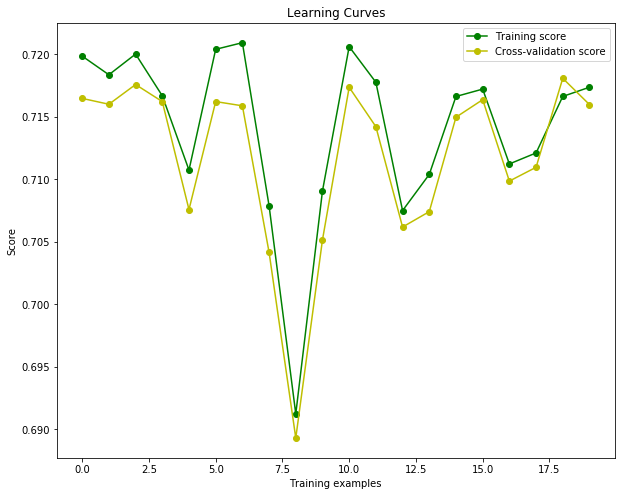

In [58]:
# with_learning_curves = True
if with_learning_curves:
    draw_learning_curves(clf_keras, X_train_sampled, y_train_sampled, 
                         n_jobs=1, random_state=random_state, scoring=scorer)

For comparison, the learning curve of the LogisticRegression classifier: 

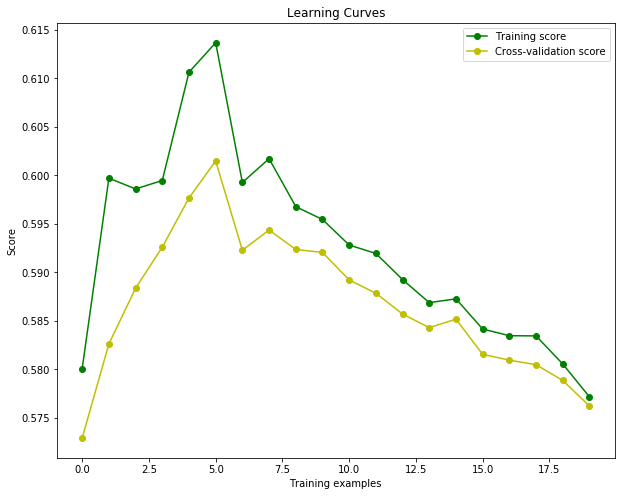

In [59]:
if with_learning_curves:
    draw_learning_curves(clfs['Logistic Regression'], X_train_sampled, y_train_sampled, 
                         n_jobs=N_JOBS, random_state=random_state, scoring=scorer)

# Results

The folllowing table gives an overview over difference statistics collected for the classifiers on the test set: 

In [60]:
metricreport.report

,Classifier,Fbeta,Accuracy,TN,FP,FN,TP,Beta,Precision,Recall,F1,Support,Cost[0.1],Cost[0.3],Cost[0.5]
0,KNeighborsClassifier,0.127055,0.685472,8414,696,3318,334,1.25,0.091457,0.324272,0.142674,NaN,1847830.0,1817770.0,1787710.0
1,NaiveIntuitionClassifier,0.315904,0.632268,6965,2145,2548,1104,1.25,0.302300,0.339797,0.319954,NaN,1890068.0,1790708.0,1691348.0
2,LogisticRegression,0.463665,0.594998,5503,3519,1614,2038,1.25,0.558050,0.366745,0.442610,NaN,1921354.0,1737934.0,1554514.0
3,RandomForestClassifier,0.503484,0.546079,4394,4628,1125,2527,1.25,0.691950,0.353180,0.467660,NaN,1957995.0,1730565.0,1503135.0
4,XGBClassifier,0.510809,0.612040,5446,3576,1341,2311,1.25,0.632804,0.392560,0.484537,NaN,1912579.0,1704589.0,1496599.0
5,KerasClassifier,0.519445,0.377071,1387,7635,260,3392,1.25,0.928806,0.307609,0.462157,NaN,2077164.0,1771884.0,1466604.0


Some observations of the result statistics: 
* All classifiers deployed beat the two benchmark models in the comparison metric fbeta (1.25)
* Across the other statistics, results vary: Generall the benchmark model compary unfavorably except on Accuracy
* On the cost function, we pay attention to Cost[0.3]. This gives is both the most realistic success rate, and the mean of cost over different success rates. 
* Looking at the cost function we can see XGB performs best, resulting in savings of ~$86,000.00 over the naive benchmark model
* Optimizing for F-beta directly via optimzing Recall in Keras/Tensorflow seems to have worked insofar that the Keras classifier has the highest target score. However, this comes at the cost of poor accuracy and many false positives, which make it perform poorly on the cost function


## Precision Recall curve

We can gain additional insight on the performance of the classifiers for our problem from the precision-recall curve.

Logistic Regression: f1=0.4426 auc=0.3803 ap=0.3806
Random Forest: f1=0.4677 auc=0.3733 ap=0.3736
XGBoost: f1=0.4845 auc=0.4414 ap=0.4416
Keras: f1=0.4622 auc=0.3599 ap=0.3602


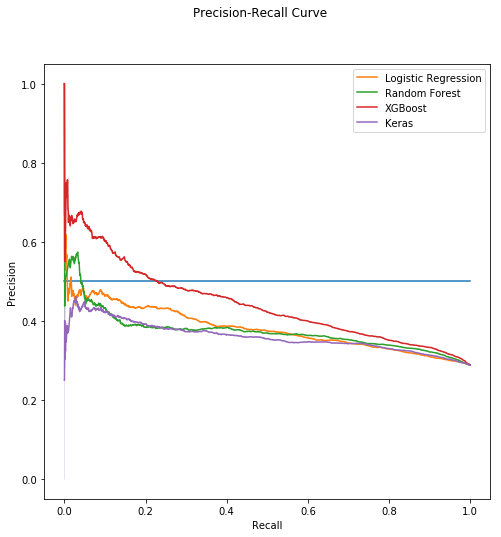

In [61]:
from sklearn.metrics import precision_recall_curve, auc as auc_score, average_precision_score, f1_score

clfs_all = clfs.copy()
clfs_all['KNN'] = clf_knn
clfs_all['Naive'] = clf_naive

fig = plt.figure(figsize = (8, 8))
plt.subplot(1, 1, 1)
plt.plot(x=[0, 1], y=[0.5, 0.5], linestyle='--')
sns.lineplot(x=[0, 1], y=[0.5, 0.5])
for name, clf in clfs.items():
    
    probs = clf.predict_proba(X_test)
    probs = probs[:, 1]
    y_pred = clf.predict(X_test)
    precision, recall, thresholds = precision_recall_curve(y_test, probs)
    f1 = f1_score(y_test, y_pred)
    auc = auc_score(recall, precision)
    
    ap = average_precision_score(y_test, probs)
    print('{0}: f1={1:.4f} auc={2:.4f} ap={3:.4f}'.format(name, f1, auc, ap))
    
    # line = plt.plot(x=recall, y=precision, label=name)
    # slower, but for some reason pyplot doesn't want to plot this
    sns.lineplot(x=recall, y=precision, label=name)


plt.suptitle('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc='best')
plt.show()

## Final model

Based on the statistics collected in our report and the review of the precision recall curve we select **XGBoost** as the solution algorithm. 

With saving savings of **~$86,000.00** over the naive benchmark model in our cost simulation we consider the problem adequately solved with this model. 